In [147]:
import pandas as pd
from fuzzywuzzy import fuzz
import IPython
%matplotlib inline
import numpy as np
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
matplotlib.style.use('ggplot')

# BUDT758X – Data Processing and Analysis in Python
# Group 4 – Guanyu Chen and Anuj Patni 

# Risk Management Tool for helping migrants gauge country risk

## __SECTION 1 - INTRODUCTION__

Nowadays people have global careers and moving to another continent for work is not considered unusual. A crucial aspect to be considered before relocating to an alien country is to know all the risks one is being exposed to in that country. We intended to create a comprehensive dashboard for professionals who seek to move to the Asia - Pacific region better understand the risks they and their families are exposed to. We find that our project has evolved from our initial vision into something else. Instead of focusing only on the Asia Pacific region we are now focusing on the entire world. Now our key objectives are – 
1.	Generate a comprehensive risk score for every country.
2.	Create a heat map using these scores and plot the countries on a world map.
3.	Create clusters of countries to better visualize safe,moderate and risky countries.
4.  Find out what are the factors impacting the risk score of a specific country.
4.	Answer some interesting questions using our findings.


### ___DESCRIPTION OF THE RISK METRIC___

During our research for an acceptable risk metric we came across the World Risk Report 2017 (Welthungerhilfe, United Nations University, medico international, Terre des hommes, CBM, Kindernothilfe) . The calculation of WorldRiskIndex was performed by the Institute for Environment and Human Security of the United Nations University (UNU-EHS) in the years 2011 to 2016 and commissioned by Bündnis Entwicklung Hilft. Because we are not social scientists and could not come up with a scientific score for measuring broad-based country risk, we decided to use the WorldRiskIndex as our risk metric. We give due credit to the World Risk Report 2016 and 2017 and thank the researchers and authors behind its publication. 

The formula for calculating country risk is divided into 4 sections namely, Exposure Score(E), Susceptibility Score(S), Lack of Coping Capacities (C) and Lack of Adaptive Capacities(A). The final country score as calculated by us is given by <font color=blue>Score = E + S + C + A </font>

 - E is defined as the Exposure to Natural Hazards
 - S is defined as the Susceptability which means the likelihood of a country suffering harm
 - C is defined as the Lack of Coping Abilities which means Lack of capacities to reduce negative consequences in the Present
 - A is defined as the Lack of Adaptive Abilities which means Lack of capacities for long-term strategies for societal change

The formula we are using is a bit different from the formula used by UNU. We changed the formula after reading their report and applying our own thoughts to this problem.

The image shown in the next cell explains in detail how the UNU went about creating its risk metric. Its a very simple mathematical formula but as evident from the image, the challenges we faced were -  
 - Being able access so many datasets without any knowledge of the datasets UNU used
 - Ensuring that these sources are somewhat credible
 - Merging so many files and creating a risk metric
 - Taking due care for missing values and mis-spellings of country names

So our main task was to be able to recreate the World Risk Index of the UNU EHS report without having access to the datasets they used. Essentially , we only had their metric and this image below as our guiding beacon. In all , we had to get information on 25 datasets to be able to generate our Risk Index.

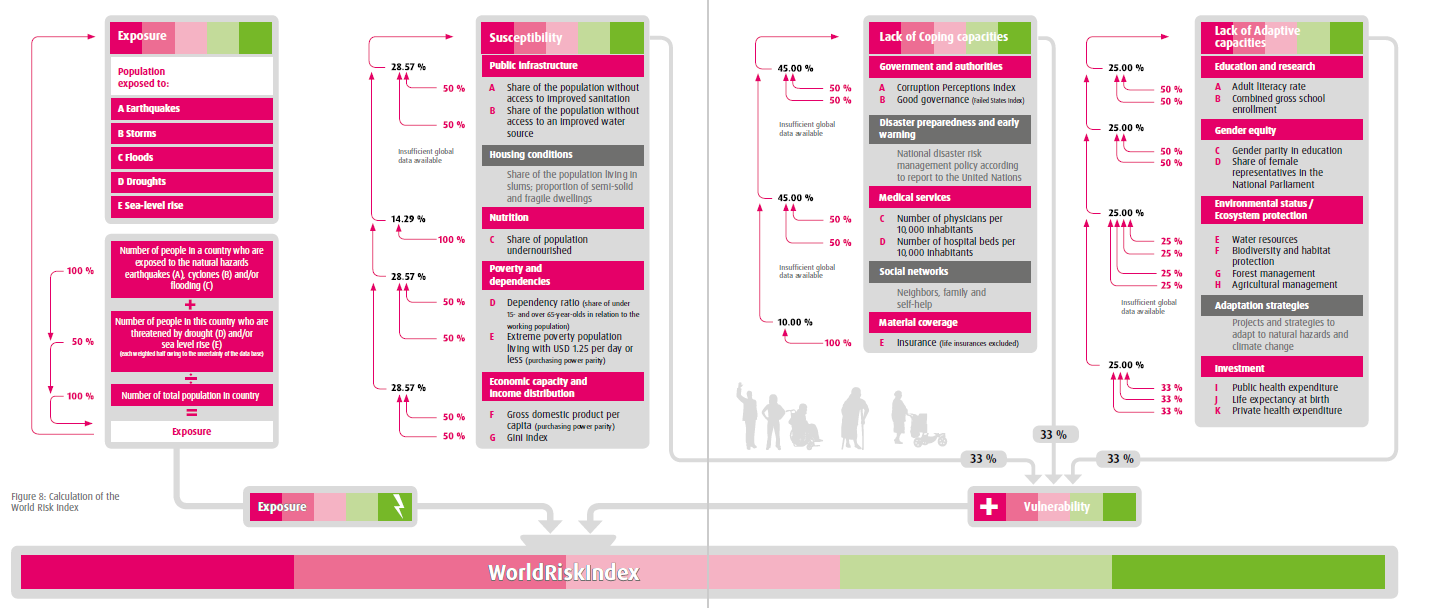

In [49]:
IPython.display.Image('Image1.PNG')

Figure 1 - WorldRiskIndex as calculated by the UNU EHS World Ris Report 2016<br>
_Image acknowledgement - UNU EHS World Risk Report 2016 http://collections.unu.edu/view/UNU:5763 _

### ___SOURCES OF DATA___

We used a number of sources to get the information we needed. A detailed list of our sources are shown in Image 2 right below this cell. The index of the table specifies a alphanumeric code starting with E,S,C or A. So E5 tells us that this file is being used for the 5th metric of the Exposure score calculation. E,S,C and A are defined in the section previous to Image 1. In all we had 8 sources to create our 25 dataframes.

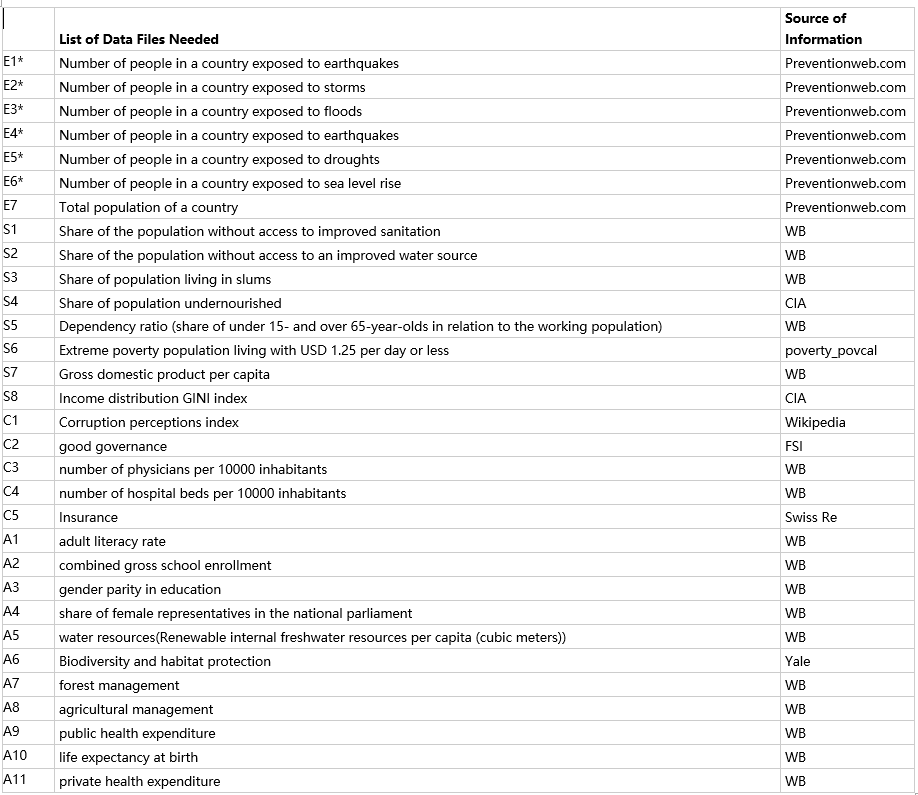

In [50]:
IPython.display.Image('Image2.PNG')

Figure 2 - Source of Information<br>[ * ] indicates that the metric was not available and we used a proxy parameter instead. So for example, percentage of the population of Thailand that is exposed to earthquakes is not known. But we know the value of loss expected from earthquakes in USD million. By dividing this by the Gross Domestic Product of Thailand we can arrive at a comparable proxy.

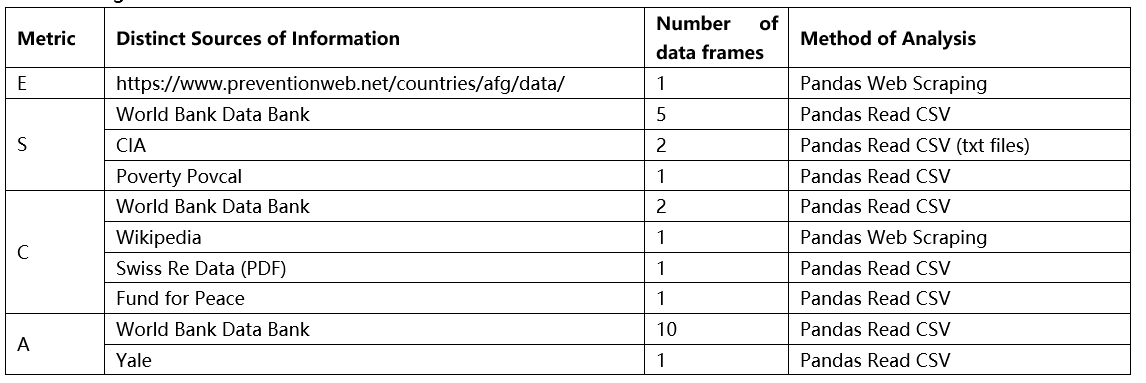

In [51]:
IPython.display.Image('Image3.PNG')

Figure 3 - Description of Source, the number of pandas dataframe created and method of analysis

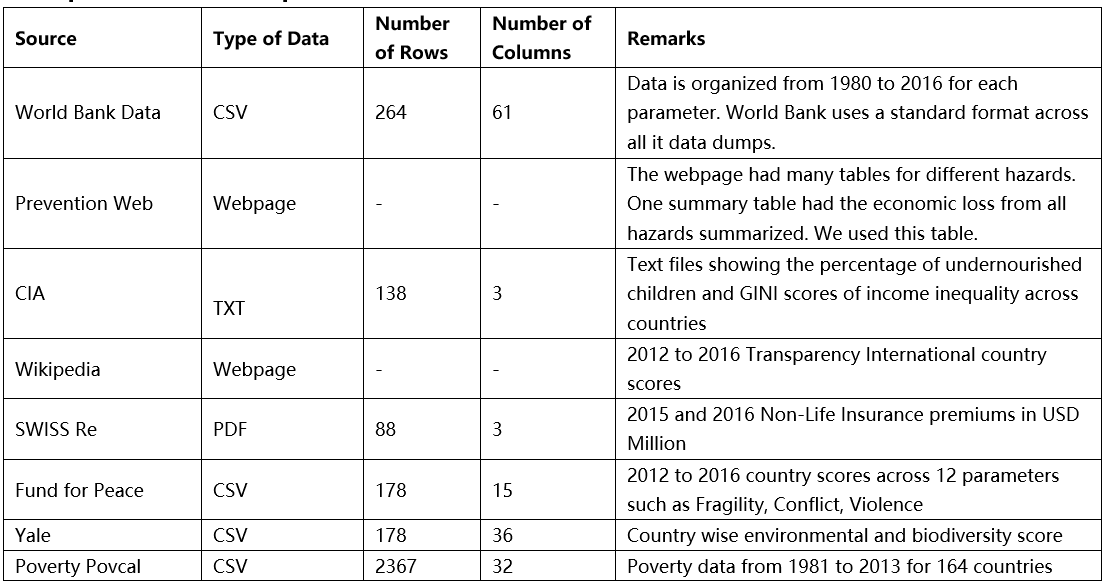

In [52]:
IPython.display.Image('Image4.PNG')

Figure 4 - Description of Data Sources, number of rows and columns of each source of data

***
                                                    End of Section 1 - INTRODUCTION
***

## __SECTION 2 - DATA PREPARATION BEFORE ANALYSIS__

Broadly our task in this section was to do the following - 
1.	Read each source file into a pandas dataframe. For example, read the GDP CSV from World Bank.
2.	Drop the columns that are not needed and perform data cleaning to remove any inconsistencies. 
3.	Calculate the average score across 2012 to 2016 – if any value was missing we skipped it. So for example if we had values as 2,2,3,NAN,1 then we calculated the average as (2+2+3+1) / 4.
4.	Then use the standard country list in the index and then create a new column called ‘GDP’ and add these values into it. Use the fuzzy wuzzy package to identify countries that are mis-spelt. 
5.  If any country's score is missing then we used the mean score of all countries to fill NAs.
6.	Do this for all the 25 parameters.
7.	Use the details in Figure 2 and convert the 25 dataframe into into just 4 required dataframes, 1 each for E,S,C and A.

### Building the 'E' - Exposure to Natural Hazards Dataframe

#### Step 1:Get country list

<font color=blue>Use the World Bank country list as our standard country list </font>

In [11]:
df_WBCountry=pd.read_csv('Country_List_WB.csv')
df_WBCountry=df_WBCountry.set_index('Country')
df_WBCountry.head(3)

""
Country
Aruba
Afghanistan
Angola


#### Step 2:Scrape Abbreviation for every country

<font color=blue> Build the Alpha 3 country code in preparation for the webscraping in the next step </font>

In [12]:
url_country='http://www.nationsonline.org/oneworld/country_code_list.htm'
df_country=pd.read_html(url_country,header=0)[2]
df_country=df_country.drop(columns=['Unnamed: 0'])
df_country=df_country.drop([0])
df_country.columns=['Country','Alpha_2','Alpha_3','NumCode']
df_country.head(3)

,Country,Alpha_2,Alpha_3,NumCode
1,Afghanistan,AF,AFG,4.0
2,Aland Islands,AX,ALA,248.0
3,Albania,AL,ALB,8.0


#### Step 3:Scrape Hazard Loss data for every country

<font color=blue>This next piece of code takes more than 5minutes to run. Hazard Loss is calculated as the Absolute loss a country is exposed to (in USD Million) divided by the country's population. So you can say this is Hazard Loss USD million per capita. A screenshot from the website we are trying to scrape is shown immediately below. </font>

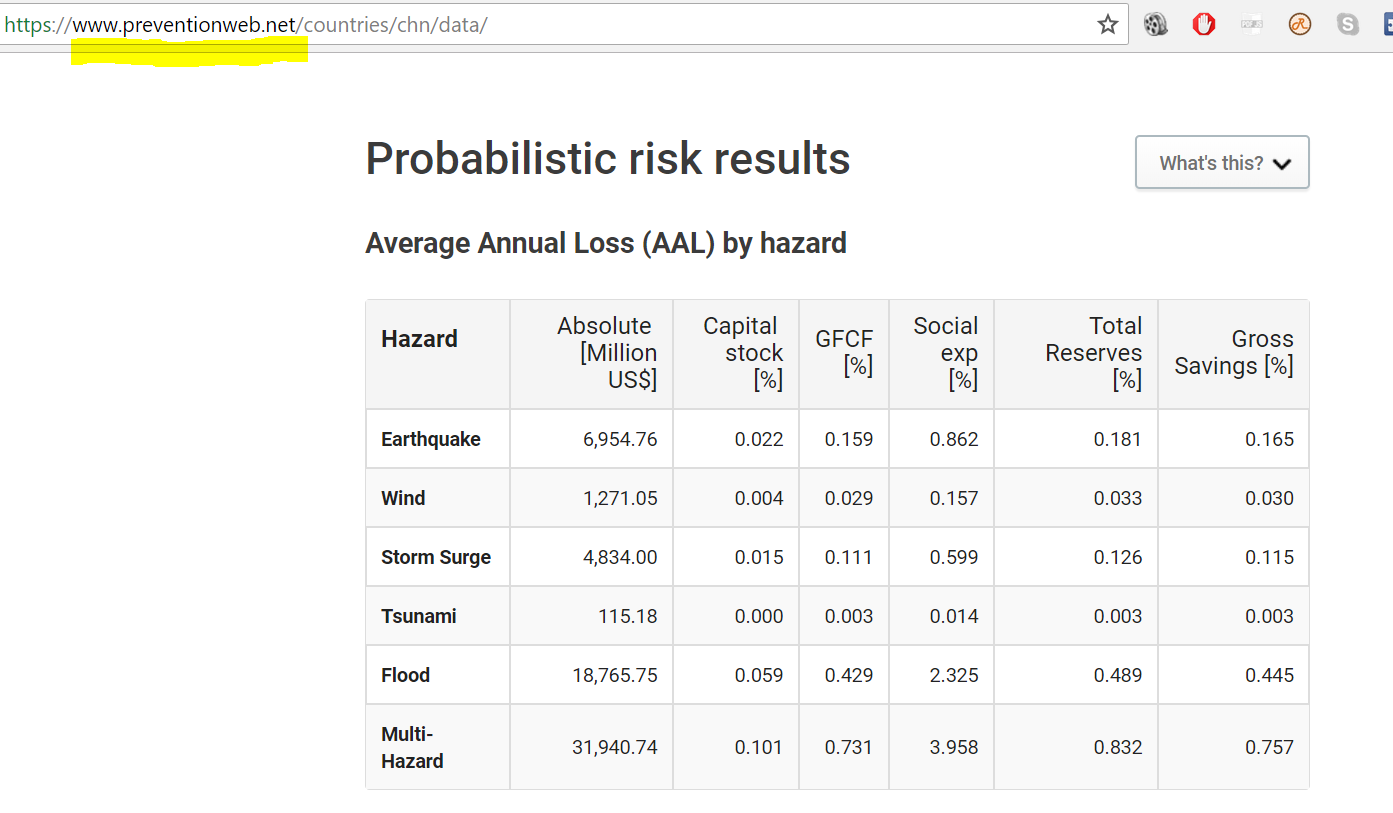

In [54]:
IPython.display.Image('Image5.PNG')

Figure 5 - Hazard Loss exposure of China (Alpha 3 code - chn) in USD million

In [14]:
# Use abbreviation to change url then get different country information
Hazard_Loss={}
for i in df_country.Alpha_3.str.lower():
        url_hazard='https://www.preventionweb.net/countries/%s/data/'%i
        try:
            df_hazards=pd.read_html(url_hazard,header=0,match='Hazard')[0]
        except:
            continue
        df_hazards=df_hazards.iloc[:,0:2]
        df_hazards.columns=['Hazard','Absolute Loss(Million US$)']
        hazard_sum=df_hazards['Absolute Loss(Million US$)'].sum()
        df_pop=pd.read_html(url_hazard,match='Population')[0]
        pop=df_pop.iloc[0,2]
        if(pop):Hazard_Loss_Percentage=hazard_sum/pop
        else:Hazard_Loss_Percentage=0
        Hazard_Loss[i]=Hazard_Loss_Percentage

<font color=blue> After scraping and calculating what we need, we now clean up the dataframe. We call it the Hazard Loss Dataframe. </font>

In [15]:
hazard_df=pd.DataFrame(data=Hazard_Loss,index=[0]).unstack()
hazard_df=pd.DataFrame(data=hazard_df)
hazard_df=hazard_df.reset_index()
hazard_df.columns=['Country_Abbrev','LL','HazardLossPercentage']
hazard_df=hazard_df.drop(columns='LL')

In [16]:
hazard_df.Country_Abbrev=hazard_df.Country_Abbrev.str.upper()
hazard_df=hazard_df.set_index('Country_Abbrev')
df_country=df_country.set_index('Alpha_3')
df_HazardsLoss=pd.concat([hazard_df,df_country],axis=1)
df_HazardsLoss=df_HazardsLoss.drop(columns=['Alpha_2','NumCode'])
df_HazardsLoss=df_HazardsLoss.set_index('Country')
df_HazardsLoss.head(10)

,HazardLossPercentage
Country,
Aruba,0.001079
Afghanistan,0.000016
Angola,0.000016
Anguilla,0.003718
Aland Islands,NaN
Albania,0.000056
Andorra,0.000003
Netherlands Antilles,NaN
United Arab Emirates,0.000161


<font color=blue>We use fuzzy wuzzy to correct country names and align the country names to our standardised list of country names acquired from World Bank. We then store it into a Pickle. Our first dataframe for calculating 'Exposure' is now ready. </font>

In [17]:
for m in df_HazardsLoss.index:
    for n in df_WBCountry.index:
        if fuzz.token_sort_ratio(m,n) >= 80:
            df_HazardsLoss=df_HazardsLoss.replace(m,n)
        else:
            if m not in df_WBCountry.index:
                try:
                    df_HazardsLoss=df_HazardsLoss.drop(m)
                except:
                    continue
df_HazardsLoss=pd.concat([df_WBCountry,df_HazardsLoss],axis=1)
df_HazardsLoss.head(3)

,HazardLossPercentage
Afghanistan,0.000016
Albania,0.000056
Algeria,0.000060


In [56]:
df_HazardsLoss.shape

(264, 1)

In [18]:
df_HazardsLoss.to_pickle('Exposure Score')

### Building the 'S' - Susceptability Dataframe

#### Step 1:Get country list

In [57]:
df_WBCountry=pd.read_csv('Country_List_WB.csv',header=0)
df_WBCountry.set_index('Country',inplace=True)
df_WBCountry.head(3)

""
Country
Aruba
Afghanistan
Angola


#### Step 2:Get the share of the population with access to improved sanitation and calculate the mean of 5 years, 2012-16

In [58]:
# Get columns we need and rename the columns
doc_ShrOfPpleSnt='pop_without_acess_to_improved_sanitation.csv'
df_ShrOfPpleSnt=pd.read_csv(doc_ShrOfPpleSnt,header=0,skiprows=4)
df_ShrOfPpleSnt=df_ShrOfPpleSnt[['Country Name','2012','2013','2014','2015','2016']]
df_ShrOfPpleSnt.columns=['Country','2012','2013','2014','2015','2016']
# Calculate the mean value of last few years data
df_ShrOfPpleSnt['ShrOfPpleSnt_AVG']=df_ShrOfPpleSnt.mean(skipna=True,axis=1)
df_ShrOfPpleSnt=df_ShrOfPpleSnt.drop_duplicates(['Country'],keep='first')
df_ShrOfPpleSnt.head(3)

,Country,2012,2013,2014,2015,2016,ShrOfPpleSnt_AVG
0,Aruba,97.7,97.7,97.7,97.7,NaN,97.700
1,Afghanistan,30.5,31.1,31.8,31.9,NaN,31.325
2,Angola,49.1,50.6,51.1,51.6,NaN,50.600


In [59]:
# Drop columns we already used and keep the average value
df_ShrOfPpleSnt_avg=df_ShrOfPpleSnt.drop(columns=['2012','2013','2014','2015','2016']).set_index('Country')
df_ShrOfPpleSnt_avg.head(3)

,ShrOfPpleSnt_AVG
Country,
Aruba,97.700
Afghanistan,31.325
Angola,50.600


#### Step 3:Get Share of the population with access to improved water source  and calculate the mean of 5 years, 2012-16

In [60]:
# Get columns we need and rename the columns
doc_ShrOfPpleWater='percentage_of_population_with_access_water.csv'
df_ShrOfPpleWater=pd.read_csv(doc_ShrOfPpleWater,header=0,skiprows=4)
df_ShrOfPpleWater=df_ShrOfPpleWater[['Country Name','2012','2013','2014','2015','2016']]
df_ShrOfPpleWater.columns=['Country','2012','2013','2014','2015','2016']
# Calculate the mean value of last few years data
df_ShrOfPpleWater['ShrOfPpleWater_AVG']=df_ShrOfPpleWater.mean(skipna=True,axis=1)
df_ShrOfPpleWater.head(3)

,Country,2012,2013,2014,2015,2016,ShrOfPpleWater_AVG
0,Aruba,98.1,98.1,98.1,98.1,NaN,98.100
1,Afghanistan,51.6,53.4,55.2,55.3,NaN,53.875
2,Angola,47.8,48.2,48.6,49.0,NaN,48.400


In [61]:
# Drop columns we already used and keep the average value
df_ShrOfPpleWater_avg=df_ShrOfPpleWater.drop(columns=['2012','2013','2014','2015','2016']).set_index('Country')
df_ShrOfPpleWater_avg.head(3)

,ShrOfPpleWater_AVG
Country,
Aruba,98.100
Afghanistan,53.875
Angola,48.400


#### Step 4:Get Share of population living in slums and calculate the mean of 5 years, 2012-16

In [62]:
# Get columns we need and rename the columns
doc_ShrOfPpleSlums='share of pop_live_in_slums.csv'
df_ShrOfPpleSlums=pd.read_csv(doc_ShrOfPpleSlums,header=0,skiprows=4)
df_ShrOfPpleSlums=df_ShrOfPpleSlums[['Country Name','2012','2013','2014','2015','2016']]
df_ShrOfPpleSlums.columns=['Country','2012','2013','2014','2015','2016']
# Calculate the mean value of last few years data
df_ShrOfPpleSlums['ShrOfPpleSlums_AVG']=df_ShrOfPpleSlums.mean(skipna=True,axis=1)
df_ShrOfPpleSlums.head(3)

,Country,2012,2013,2014,2015,2016,ShrOfPpleSlums_AVG
0,Aruba,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,NaN,NaN,62.7,NaN,NaN,62.7
2,Angola,NaN,NaN,55.5,NaN,NaN,55.5


In [63]:
# Drop columns we already used and keep the average value
df_ShrOfPpleSlums_avg=df_ShrOfPpleSlums.drop(columns=['2012','2013','2014','2015','2016']).set_index('Country')
df_ShrOfPpleSlums_avg.head(3)

,ShrOfPpleSlums_AVG
Country,
Aruba,NaN
Afghanistan,62.7
Angola,55.5


#### Step 5:Get the share of population undernourished (source CIA)

In [65]:
# Get columns we need and rename the columns
doc_ShrOfPpleUnder='UnderNourish.csv'
df_ShrOfPpleUnder=pd.read_csv(doc_ShrOfPpleUnder)
df_ShrOfPpleUnder=df_ShrOfPpleUnder.drop(columns=['Column1'])
df_ShrOfPpleUnder.columns=['Country','ShrOfPpleUnder_Index']
# Drop duplicated countries because of reducdant data
df_ShrOfPpleUnder=df_ShrOfPpleUnder.drop_duplicates(['Country'],keep='first')
# Remove the white space of the country name
df_ShrOfPpleUnder.Country=df_ShrOfPpleUnder['Country'].apply(lambda x: x.strip())
# Reset index for future concat
df_ShrOfPpleUnder_avg=df_ShrOfPpleUnder.set_index('Country')
df_ShrOfPpleUnder_avg.head(3)

,ShrOfPpleUnder_Index
Country,
Timor-Leste,45.3
India,43.5
Yemen,43.1


<font color=blue> Since the source of 'undernourished' data is not World Bank we use fuzzy wuzzy to correct country names and align the country names to our standardised list of country names acquired from World Bank. </font>

In [66]:
# Use fuzz to compare the country name, then use our standard country name list to filter and replace typos and different spellings
for m in df_ShrOfPpleUnder_avg.index:
    for n in df_WBCountry.index:
        if fuzz.token_sort_ratio(m,n) >= 80:
            df_ShrOfPpleUnder_avg=df_ShrOfPpleUnder_avg.replace(m,n)
        else:
            if m not in df_WBCountry.index:
                try:
                    df_ShrOfPpleUnder_avg=df_ShrOfPpleUnder_avg.drop(m)
                except:
                    continue
df_ShrOfPpleUnder_avg=pd.concat([df_WBCountry,df_ShrOfPpleUnder_avg],axis=1)
df_ShrOfPpleUnder_avg.head(3)

,ShrOfPpleUnder_Index
Afghanistan,32.9
Albania,6.3
Algeria,3.7


#### Step 6: Get Dependency ratio - share of less than 15 and over 65 olds in relation to the working population and calculate the mean over 5 years 2012-16

In [67]:
# Get columns we need and rename the columns
doc_DependencyRatio='percentage_of_population_with_access_water.csv'
df_DependencyRatio=pd.read_csv(doc_DependencyRatio,header=0,skiprows=4)
df_DependencyRatio=df_DependencyRatio[['Country Name','2012','2013','2014','2015','2016']]
df_DependencyRatio.columns=['Country','2012','2013','2014','2015','2016']
# Calculate the mean value of last few years data
df_DependencyRatio['DependencyRatio_AVG']=df_DependencyRatio.mean(skipna=True,axis=1)
df_DependencyRatio.head(3)

,Country,2012,2013,2014,2015,2016,DependencyRatio_AVG
0,Aruba,98.1,98.1,98.1,98.1,NaN,98.100
1,Afghanistan,51.6,53.4,55.2,55.3,NaN,53.875
2,Angola,47.8,48.2,48.6,49.0,NaN,48.400


In [69]:
# Drop columns we already used and keep the average value
df_DependencyRatio_avg=df_DependencyRatio.drop(columns=['2012','2013','2014','2015','2016']).set_index('Country')
df_DependencyRatio_avg.head(3)

,DependencyRatio_AVG
Country,
Aruba,98.100
Afghanistan,53.875
Angola,48.400


#### Step 7:Get Extreme poverty population living with USD 1.25 per day or less (source - Pverty Povcal)

In [70]:
# Get columns we need and rename the columns
doc_Poverty='poverty_povcal.csv'
df_Poverty=pd.read_csv(doc_Poverty,header=0)
df_Poverty['Poverty_AVG']=df_Poverty.iloc[:,11]
# Drop duplicated countries because of reducdant data
df_Poverty=df_Poverty.drop_duplicates(['CountryName'],keep='first')
df_Poverty_avg=df_Poverty.loc[:,['CountryName','Poverty_AVG']]
df_Poverty_avg.columns=['Country','Poverty_AVG']
# Reset index for future concat
df_Poverty_avg.set_index('Country',inplace=True)
df_Poverty_avg.head(3)

,Poverty_AVG
Country,
Albania,229.9804
Algeria,261.1028
Angola,125.6557


<font color=blue> Since the source of 'extreme poverty' data is not World Bank we use fuzzy wuzzy to correct country names and align the country names to our standardised list of country names acquired from World Bank. </font>

In [71]:
# Use fuzz to compare the country name, then use our standard country name list to filter and replace typos and different spellings
for m in df_Poverty_avg.index:
    for n in df_WBCountry.index:
        if fuzz.token_sort_ratio(m,n) >= 80:
            df_Poverty_avg=df_Poverty_avg.replace(m,n)
        else:
            if m not in df_WBCountry.index:
                try:
                    df_Poverty_avg=df_Poverty_avg.drop(m)
                except:
                    continue
df_Poverty_avg=pd.concat([df_WBCountry,df_Poverty_avg],axis=1)
df_Poverty_avg.head(3)

,Poverty_AVG
Afghanistan,NaN
Albania,229.9804
Algeria,261.1028


#### Step 8:Get Gross domestic product per capita and calculate mean for 5 years, 2012-16

In [72]:
# Get columns we need and rename the columns
doc_GDP='gdp_per_capital_constant_2011.csv'
df_GDP=pd.read_csv(doc_GDP,header=0,skiprows=4)
df_GDP=df_GDP[['Country Name','2012','2013','2014','2015','2016']]
df_GDP.columns=['Country','2012','2013','2014','2015','2016']
# Calculate the mean value of last few years data
df_GDP['GDP_AVG']=df_GDP.mean(skipna=True,axis=1)
df_GDP.head(3)

,Country,2012,2013,2014,2015,2016,GDP_AVG
0,Aruba,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1839.273579,1848.700026,1838.960244,1809.016488,1802.695566,1827.729181
2,Angola,5998.638601,6185.013829,6260.132681,6231.067992,5984.640422,6131.898705


In [73]:
# Drop columns we already used and keep the average value
df_GDP_avg=df_GDP.drop(columns=['2012','2013','2014','2015','2016']).set_index('Country')
df_GDP_avg.head(3)

,GDP_AVG
Country,
Aruba,NaN
Afghanistan,1827.729181
Angola,6131.898705


#### Step 9:Get Income distribution GINI index (source CIA)

In [74]:
# Get columns we need and rename the columns
doc_GINI='GINI_Index.csv'
df_GINI=pd.read_csv(doc_GINI)
df_GINI=df_GINI.drop(columns=['Column1'])
df_GINI.columns=['Country','IncmGINI_Index']
# Drop duplicated countries because of reducdant data
df_GINI=df_GINI.drop_duplicates(['Country'],keep='first')
# Remove the white space of the country name
df_GINI.Country=df_GINI.Country.apply(lambda x: x.strip())
# Reset index for future concat
df_GINI_avg=df_GINI.set_index('Country')
df_GINI_avg.head(3)

,IncmGINI_Index
Country,
Lesotho,63.2
South Africa,62.5
"Micronesia, Federated States of",61.1


<font color=blue> Since the source of 'GINI' data is not World Bank we use fuzzy wuzzy to correct country names and align the country names to our standardised list of country names acquired from World Bank. </font>

In [75]:
# Use fuzz to compare the country name, then use our standard country name list to filter and replace typos and different spellings
for m in df_GINI_avg.index:
    for n in df_WBCountry.index:
        if fuzz.token_sort_ratio(m,n) >= 80:
            df_GINI_avg=df_GINI_avg.replace(m,n)
        else:
            if m not in df_WBCountry.index:
                try:
                    df_GINI_avg=df_GINI_avg.drop(m)
                except:
                    continue
df_GINI_avg=pd.concat([df_WBCountry,df_GINI_avg],axis=1)
df_GINI_avg.head(3)

,IncmGINI_Index
Afghanistan,NaN
Albania,29.0
Algeria,35.3


#### Step 10: Combine all 8 dataframes and create one 'S' Susceptability Dataframe

<font color=blue> If there exists any country that is missing data on any of these 8 columns, then the column mean is assigned to that country's missing column value. </font>

In [76]:
# According to country name which is index to concat all dataframes into one dataframe
df_SusceptabilityScore=pd.concat([df_WBCountry,df_ShrOfPpleSnt_avg,df_ShrOfPpleWater_avg,df_ShrOfPpleSlums_avg,df_ShrOfPpleUnder_avg,df_DependencyRatio_avg,df_Poverty_avg,df_GDP_avg,df_GINI_avg],axis=1)
df_SusceptabilityScore=df_SusceptabilityScore.apply(lambda x: x.fillna(x.mean()))
df_SusceptabilityScore.head(10)

,ShrOfPpleSnt_AVG,ShrOfPpleWater_AVG,ShrOfPpleSlums_AVG,ShrOfPpleUnder_Index,DependencyRatio_AVG,Poverty_AVG,GDP_AVG,IncmGINI_Index
Afghanistan,31.325000,53.875000,62.700000,32.900000,53.875000,476.165884,1827.729181,39.076642
Albania,92.800000,95.200000,43.975592,6.300000,95.200000,229.980400,10778.842674,29.000000
Algeria,87.300000,84.250000,43.975592,3.700000,84.250000,261.102800,13508.963777,35.300000
American Samoa,62.500000,100.000000,43.975592,12.769106,100.000000,476.165884,17564.061213,39.076642
Andorra,100.000000,100.000000,43.975592,12.769106,100.000000,476.165884,17564.061213,39.076642
Angola,50.600000,48.400000,55.500000,15.600000,48.400000,125.655700,6131.898705,42.700000
Antigua and Barbuda,72.196752,97.900000,43.975592,12.769106,97.900000,476.165884,19722.550786,39.076642
Arab World,84.370610,88.526687,32.410183,12.769106,88.526687,476.165884,15159.478312,39.076642
Argentina,95.950000,98.850000,16.700000,2.300000,98.850000,645.461200,19019.068985,42.700000
Armenia,89.500000,99.900000,14.400000,5.300000,99.900000,182.367300,7919.270488,31.500000


<font color=blue> Save the 'S' dataframe as a Pickle. </font>

In [77]:
# Save as pickle for future use
df_SusceptabilityScore.to_pickle('Susceptability Score')

### Building the 'C' - Lack of Coping Capacity Dataframe

#### Step 1:Get country list

In [78]:
df_WBCountry=pd.read_csv('Country_List_WB.csv',header=0)
df_WBCountry.set_index('Country',inplace=True)
df_WBCountry.head(3)

""
Country
Aruba
Afghanistan
Angola


#### Step 2:Get corruption index and calculate the 5 year mean 2012-16

In [79]:
# Scrape data from wikipedia 
url_crpt='https://en.wikipedia.org/wiki/Corruption_Perceptions_Index'
df_crpt=pd.read_html(url_crpt,header=0)[4]
# Get columns we need and rename the columns
df_crpt.columns=['Rank','Country','2016','Change','2015','Change','2014','Change','2013','Change','2012']
df_crpt=df_crpt.drop([0]).reset_index(drop=True)
df_crpt=df_crpt.drop(columns=['Rank','Change','Change','Change','Change'])
df_crpt.iloc[:,1:6]=df_crpt.iloc[:,1:6].astype(float)
# Calculate the mean value of last few years data
df_crpt['CorruptionIndex_AVG']=df_crpt.mean(skipna=True,axis=1)
# Drop duplicated countries because of reducdant data
df_crpt=df_crpt.drop_duplicates(['Country'],keep='first')
df_crpt.head(3)

,Country,2016,2015,2014,2013,2012,CorruptionIndex_AVG
0,Denmark,90.0,91.0,92.0,91.0,90.0,90.8
1,New Zealand,90.0,91.0,91.0,91.0,90.0,90.6
2,Finland,89.0,90.0,89.0,89.0,90.0,89.4


In [80]:
# Drop columns we already used and keep the average value
df_crpt_avg=df_crpt.drop(columns=['2016','2015','2014','2013','2012']).set_index('Country')
df_crpt_avg.head(3)

,CorruptionIndex_AVG
Country,
Denmark,90.8
New Zealand,90.6
Finland,89.4


<font color=blue> Since the source of 'Corruption' data is not World Bank we use fuzzy wuzzy to correct country names and align the country names to our standardised list of country names acquired from World Bank. </font>

In [81]:
# Use fuzz to compare the country name, then use our standard country name list to filter and replace typos and different spellings
for m in df_crpt_avg.index:
    for n in df_WBCountry.index:
        if fuzz.token_sort_ratio(m,n) >= 80:
            df_crpt_avg=df_crpt_avg.replace(m,n)
        else:
            if m not in df_WBCountry.index:
                try:
                    df_crpt_avg=df_crpt_avg.drop(m)
                except:
                    continue
df_crpt_avg=pd.concat([df_WBCountry,df_crpt_avg],axis=1)
df_crpt_avg.head(3)

,CorruptionIndex_AVG
Afghanistan,10.8
Albania,34.4
Algeria,35.2


#### Step 3:Get Good Governance score (source - FSI) and calculate 5 year mean

In [82]:
# Get columns we need and rename the columns
path_Fragile2017='fsi-2017.xlsx'
df_Fragile2017=pd.read_excel(path_Fragile2017,header=0)
df_Fragile2017=df_Fragile2017.drop(columns=['Year'])
# Drop columns we don't need
df_Fragile2017.columns=['Country','Rank','GoodGvncScr2017','Security Apparatus','Factionalized Elites','Group Grievance','Economy','Economic Inequality','Human Flight and Brain Drain','State Legitimacy','Public Services','Human Rights','Demographic Pressures','Refugees and IDPs','External Intervention']
df_Fragile2017=df_Fragile2017.drop(columns=['Rank','Security Apparatus','Factionalized Elites','Group Grievance','Economy','Economic Inequality','Human Flight and Brain Drain','State Legitimacy','Public Services','Human Rights','Demographic Pressures','Refugees and IDPs','External Intervention'])
df_Fragile2017.head(3)

,Country,GoodGvncScr2017
0,South Sudan,113.9
1,Somalia,113.4
2,Central African Republic,112.6


In [83]:
# Get columns we need and rename the columns
path_Fragile2016='fsi-2016.xlsx'
df_Fragile2016=pd.read_excel(path_Fragile2016,header=0)
# Drop columns we don't need
df_Fragile2016=df_Fragile2016.drop(columns=['Year'])
df_Fragile2016.columns=['Country','Rank','GoodGvncScr2016','Security Apparatus','Factionalized Elites','Group Grievance','Economy','Economic Inequality','Human Flight and Brain Drain','State Legitimacy','Public Services','Human Rights','Demographic Pressures','Refugees and IDPs','External Intervention']
df_Fragile2016=df_Fragile2016.drop(columns=['Rank','Security Apparatus','Factionalized Elites','Group Grievance','Economy','Economic Inequality','Human Flight and Brain Drain','State Legitimacy','Public Services','Human Rights','Demographic Pressures','Refugees and IDPs','External Intervention'])
df_Fragile2016.head(3)

,Country,GoodGvncScr2016
0,Somalia,114.0
1,South Sudan,113.8
2,Central African Republic,112.1


In [84]:
# Get columns we need and rename the columns
path_Fragile2015='fsi-2015.xlsx'
df_Fragile2015=pd.read_excel(path_Fragile2015,header=0)
df_Fragile2015=df_Fragile2015.drop(columns=['Year'])
# Drop columns we don't need
df_Fragile2015.columns=['Country','Rank','GoodGvncScr2015','Security Apparatus','Factionalized Elites','Group Grievance','Economy','Economic Inequality','Human Flight and Brain Drain','State Legitimacy','Public Services','Human Rights','Demographic Pressures','Refugees and IDPs','External Intervention']
df_Fragile2015=df_Fragile2015.drop(columns=['Rank','Security Apparatus','Factionalized Elites','Group Grievance','Economy','Economic Inequality','Human Flight and Brain Drain','State Legitimacy','Public Services','Human Rights','Demographic Pressures','Refugees and IDPs','External Intervention'])
df_Fragile2015.head(3)

,Country,GoodGvncScr2015
0,South Sudan,114.5
1,Somalia,114.0
2,Central African Republic,111.9


In [85]:
# Get columns we need and rename the columns
path_Fragile2014='fsi-2014.xlsx'
df_Fragile2014=pd.read_excel(path_Fragile2014,header=0)
df_Fragile2014=df_Fragile2014.drop(columns=['Year'])
# Drop columns we don't need
df_Fragile2014.columns=['Country','Rank','GoodGvncScr2014','Security Apparatus','Factionalized Elites','Group Grievance','Economy','Economic Inequality','Human Flight and Brain Drain','State Legitimacy','Public Services','Human Rights','Demographic Pressures','Refugees and IDPs','External Intervention']
df_Fragile2014=df_Fragile2014.drop(columns=['Rank','Security Apparatus','Factionalized Elites','Group Grievance','Economy','Economic Inequality','Human Flight and Brain Drain','State Legitimacy','Public Services','Human Rights','Demographic Pressures','Refugees and IDPs','External Intervention'])
df_Fragile2014.head(3)

,Country,GoodGvncScr2014
0,South Sudan,112.9
1,Somalia,112.6
2,Central African Republic,110.6


In [86]:
# Get columns we need and rename the columns
path_Fragile2013='fsi-2013.xlsx'
df_Fragile2013=pd.read_excel(path_Fragile2013,header=0)
df_Fragile2013=df_Fragile2013.drop(columns=['Year'])
# Drop columns we don't need
df_Fragile2013.columns=['Country','Rank','GoodGvncScr2013','Security Apparatus','Factionalized Elites','Group Grievance','Economy','Economic Inequality','Human Flight and Brain Drain','State Legitimacy','Public Services','Human Rights','Demographic Pressures','Refugees and IDPs','External Intervention']
df_Fragile2013=df_Fragile2013.drop(columns=['Rank','Security Apparatus','Factionalized Elites','Group Grievance','Economy','Economic Inequality','Human Flight and Brain Drain','State Legitimacy','Public Services','Human Rights','Demographic Pressures','Refugees and IDPs','External Intervention'])
df_Fragile2013.head(3)

,Country,GoodGvncScr2013
0,Somalia,113.9
1,Congo Democratic Republic,111.9
2,Sudan,111.0


In [87]:
# Get columns we need and rename the columns
path_Fragile2012='fsi-2012.xlsx'
df_Fragile2012=pd.read_excel(path_Fragile2012,header=0)
df_Fragile2012=df_Fragile2012.drop(columns=['Year'])
# Drop columns we don't need
df_Fragile2012.columns=['Country','Rank','GoodGvncScr2012','Security Apparatus','Factionalized Elites','Group Grievance','Economy','Economic Inequality','Human Flight and Brain Drain','State Legitimacy','Public Services','Human Rights','Demographic Pressures','Refugees and IDPs','External Intervention']
df_Fragile2012=df_Fragile2012.drop(columns=['Rank','Security Apparatus','Factionalized Elites','Group Grievance','Economy','Economic Inequality','Human Flight and Brain Drain','State Legitimacy','Public Services','Human Rights','Demographic Pressures','Refugees and IDPs','External Intervention'])
df_Fragile2012.head(3)

,Country,GoodGvncScr2012
0,Somalia,114.9
1,Congo Democratic Republic,111.2
2,Sudan,109.4


<font color=blue> Since the source of the 'good governance' data is not World Bank we use extra steps for processing and thereafter use fuzzy wuzzy to correct country names and align the country names to our standardised list of country names acquired from World Bank. </font>

In [88]:
# Set index and then concat all historical data
df_Fragile2012=df_Fragile2012.set_index('Country')
df_Fragile2013=df_Fragile2013.set_index('Country')
df_Fragile2014=df_Fragile2014.set_index('Country')
df_Fragile2015=df_Fragile2015.set_index('Country')
df_Fragile2016=df_Fragile2016.set_index('Country')
df_Fragile2017=df_Fragile2017.set_index('Country')
df_Fragile=pd.concat([df_Fragile2012,df_Fragile2013,df_Fragile2014,df_Fragile2015,df_Fragile2016,df_Fragile2017], axis=1)
# Calculate the mean value of the historical data
df_Fragile['GoodGvncScr_AVG']=df_Fragile.mean(skipna=True,axis=1)
df_Fragile.head(3)

,GoodGvncScr2012,GoodGvncScr2013,GoodGvncScr2014,GoodGvncScr2015,GoodGvncScr2016,GoodGvncScr2017,GoodGvncScr_AVG
Afghanistan,106.0,106.7,106.5,107.9,107.9,107.3,107.050000
Albania,66.1,65.2,63.6,61.9,61.2,60.5,63.083333
Algeria,78.1,78.7,78.8,79.6,78.3,76.8,78.383333


In [89]:
# Drop columns we already used and keep the average value
df_Fragile_avg=df_Fragile.drop(columns=['GoodGvncScr2012','GoodGvncScr2013','GoodGvncScr2014','GoodGvncScr2015','GoodGvncScr2016','GoodGvncScr2017'])
df_Fragile_avg.head(3)

,GoodGvncScr_AVG
Afghanistan,107.050000
Albania,63.083333
Algeria,78.383333


In [90]:
# Use fuzz to compare the country name, then use our standard country name list to filter and replace typos and different spellings
for m in df_Fragile_avg.index:
    for n in df_WBCountry.index:
        if fuzz.token_sort_ratio(m,n) >= 80:
            df_Fragile_avg=df_Fragile_avg.replace(m,n)
        else:
            if m not in df_WBCountry.index:
                try:
                    df_Fragile_avg=df_Fragile_avg.drop(m)
                except:
                    continue
df_Fragile_avg=pd.concat([df_WBCountry,df_Fragile_avg],axis=1)
df_Fragile_avg.head(3)

,GoodGvncScr_AVG
Afghanistan,107.050000
Albania,63.083333
Algeria,78.383333


#### Step 4:Get number of physicians per 10000 inhabitants

In [91]:
# Get columns we need and rename the columns
doc_NumOfPhyInhab='number_of_physicians_per_10000_inhabitants.csv'
df_NumOfPhyInhab=pd.read_csv(doc_NumOfPhyInhab,header=0,skiprows=4)
df_NumOfPhyInhab=df_NumOfPhyInhab[['Country Name','2012','2013','2014','2015','2016']]
df_NumOfPhyInhab.columns=['Country','2012','2013','2014','2015','2016']
# Calculate the mean value of last few years data
df_NumOfPhyInhab['NumOfPhyInhab_AVG']=df_NumOfPhyInhab.mean(skipna=True,axis=1)
df_NumOfPhyInhab.head(3)

,Country,2012,2013,2014,2015,2016,NumOfPhyInhab_AVG
0,Aruba,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,0.253,0.299,0.304,NaN,NaN,0.285333
2,Angola,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
# Drop columns we already used and keep the average value
df_NumOfPhyInhab_avg=df_NumOfPhyInhab.drop(columns=['2012','2013','2014','2015','2016']).set_index('Country')
df_NumOfPhyInhab_avg.head(3)

,NumOfPhyInhab_AVG
Country,
Aruba,NaN
Afghanistan,0.285333
Angola,NaN


#### Step 5:Get number of hospital beds per 10000 inhabitants

In [93]:
# Get columns we need and rename the columns
doc_NumOfHospBed='hospital_bed_per_10000_people.csv'
df_NumOfHospBed=pd.read_csv(doc_NumOfHospBed,header=0,skiprows=4)
df_NumOfHospBed=df_NumOfHospBed[['Country Name','2012','2013','2014','2015','2016']]
df_NumOfHospBed.columns=[['Country','2012','2013','2014','2015','2016']]
# Calculate the mean value of last few years data
df_NumOfHospBed['NumOfHospBed_AVG']=df_NumOfHospBed.mean(skipna=True,axis=1)
df_NumOfHospBed.head(3)

,Country,2012,2013,2014,2015,2016,NumOfHospBed_AVG
0,Aruba,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,0.5,NaN,NaN,NaN,NaN,0.5
2,Angola,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
# Drop columns we already used and keep the average value
df_NumOfHospBed_avg=df_NumOfHospBed.copy()
for i in ['2012','2013','2014','2015','2016']:
    del df_NumOfHospBed_avg[i]
df_NumOfHospBed_avg.set_index(list(df_NumOfHospBed_avg['Country']),drop=True,inplace=True)
df_NumOfHospBed_avg.index.name='Country'
df_NumOfHospBed_avg.columns=['NumOfHospBed_AVG']
df_NumOfHospBed_avg.head(3)

,NumOfHospBed_AVG
Country,
Aruba,NaN
Afghanistan,0.5
Angola,NaN


#### Step 6:Get the Non Lif Premium volume in 2015 and 2016 and take the mean (source - Swiss Re)
<font color=blue> To extract this information we had to first convert the information from Swiss RE into a CSV. We used a web based application to do this for us. Thereafter, we used the CSV for our analysis. </font>

In [96]:
# Get columns we need and rename the columns
doc_Insurance='insurance.csv'
df_Insurance=pd.read_csv(doc_Insurance,skiprows=1)
df_Insurance=df_Insurance.iloc[0:88,:]
# Calculate the mean value of last few years data
df_Insurance['Insurance_AVG']=df_Insurance.mean(skipna=True,axis=1)
# Drop duplicated countries because of reducdant data
df_Insurance=df_Insurance.drop_duplicates(['Country'],keep='first')
df_Insurance.head(3)

,Country,2016,2015,Insurance_AVG
0,UnitedStates,793538,763754,778646.0
1,Canada,64547,64812,64679.5
2,Brazil,31641,31979,31810.0


In [97]:
# Drop columns we already used and keep the average value
df_Insurance_avg=df_Insurance.drop(columns=['2016','2015']).set_index('Country')
df_Insurance_avg.head(3)

,Insurance_AVG
Country,
UnitedStates,778646.0
Canada,64679.5
Brazil,31810.0


<font color=blue> Since the source of 'Insurance' data is not World Bank we use fuzzy wuzzy to correct country names and align the country names to our standardised list of country names acquired from World Bank. </font>

In [98]:
# Use fuzz to compare the country name, then use our standard country name list to filter and replace typos and different spellings
for m in df_Insurance_avg.index:
    for n in df_WBCountry.index:
        if fuzz.token_sort_ratio(m,n) >= 80:
            df_Insurance_avg=df_Insurance_avg.replace(m,n)
        else:
            if m not in df_WBCountry.index:
                try:
                    df_Insurance_avg=df_Insurance_avg.drop(m)
                except:
                    continue
df_Insurance_avg=pd.concat([df_WBCountry,df_Insurance_avg],axis=1)
df_Insurance_avg.head(3)

,Insurance_AVG
Afghanistan,NaN
Albania,NaN
Algeria,1140.0


#### Step 7:Combine all 5 dataframes and create the 'Lack of Coping Capacities' dataframe

<font color=blue> If there exists any country that is missing data on any of these 5 columns, then the column mean is assigned to that country's missing column value. </font>

In [99]:
# According to country name which is index to concat all dataframes into one dataframe
df_LackOfCopingCapacities=pd.concat([df_WBCountry,df_crpt_avg,df_Fragile_avg,df_NumOfPhyInhab_avg,df_NumOfHospBed_avg,df_Insurance_avg],axis=1)
df_LackOfCopingCapacities=df_LackOfCopingCapacities.apply(lambda x: x.fillna(x.mean()))
df_LackOfCopingCapacities.head(10)

,CorruptionIndex_AVG,GoodGvncScr_AVG,NumOfPhyInhab_AVG,NumOfHospBed_AVG,Insurance_AVG
Afghanistan,10.800000,107.050000,0.285333,0.500000,12707.75
Albania,34.400000,63.083333,1.284500,2.600000,12707.75
Algeria,35.200000,78.383333,2.001259,2.997777,1140.00
American Samoa,43.592763,68.961563,2.001259,2.997777,12707.75
Andorra,43.592763,68.961563,3.689000,2.997777,12707.75
Angola,19.400000,88.183333,2.001259,2.997777,796.00
Antigua and Barbuda,43.592763,57.450000,2.001259,2.997777,12707.75
Arab World,43.592763,68.961563,1.316814,1.149876,12707.75
Argentina,34.200000,47.350000,3.762000,4.700000,13946.50
Armenia,35.000000,70.850000,2.806333,3.900000,12707.75


<font color=blue> Convert this dataframe into a Pickle for future use. </font>

In [100]:
df_LackOfCopingCapacities.to_pickle('Lack Of Coping Capacities')

### Building the 'A' - Lack of Adaptive Capacity Dataframe

#### Step 1:Get country list

In [101]:
df_WBCountry=pd.read_csv('Country_List_WB.csv',header=0)
df_WBCountry.set_index('Country',inplace=True)
df_WBCountry.head(3)

""
Country
Aruba
Afghanistan
Angola


#### Step 2:Get adult literacy rate and calculate the mean of 5 years, 2012-16

In [106]:
# Get columns we need and rename the columns
doc_AdtLtrcy='adult_literacy_rate.csv'
df_AdtLtrcy=pd.read_csv(doc_AdtLtrcy,header=0,skiprows=4)
df_AdtLtrcy=df_AdtLtrcy[['Country Name','2012','2013','2014','2015','2016']]
df_AdtLtrcy.columns=['Country','2012','2013','2014','2015','2016']
# Calculate the mean value of last few years data
df_AdtLtrcy['AdtLtrcy_AVG']=df_AdtLtrcy.mean(skipna=True,axis=1)
df_AdtLtrcy=df_AdtLtrcy.drop_duplicates(['Country'],keep='first')
df_AdtLtrcy.head(3)

,Country,2012,2013,2014,2015,2016,AdtLtrcy_AVG
0,Aruba,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,NaN,NaN,66.03011,NaN,NaN,66.03011


In [107]:
# Drop columns we already used and keep the average value
df_AdtLtrcy_avg=df_AdtLtrcy.drop(columns=['2012','2013','2014','2015','2016']).set_index('Country')
df_AdtLtrcy_avg.head(3)

,AdtLtrcy_AVG
Country,
Aruba,NaN
Afghanistan,NaN
Angola,66.03011


#### Step 3:Get combined gross school enrollment  and calculate the mean of 5 years, 2012-16

In [108]:
# Get columns we need and rename the columns
doc_CmbGrsSchl='combined_gross_school_enrollment.csv'
df_CmbGrsSchl=pd.read_csv(doc_CmbGrsSchl,header=0,skiprows=4)
df_CmbGrsSchl=df_CmbGrsSchl[['Country Name','2012','2013','2014','2015','2016']]
df_CmbGrsSchl.columns=['Country','2012','2013','2014','2015','2016']
# Calculate the mean value of last few years data
df_CmbGrsSchl['CmbGrsSchl_AVG']=df_CmbGrsSchl.mean(skipna=True,axis=1)
df_CmbGrsSchl.head(3)

,Country,2012,2013,2014,2015,2016,CmbGrsSchl_AVG
0,Aruba,37.755692,16.195829,16.40542,15.27378,NaN,21.407680
1,Afghanistan,NaN,NaN,8.66280,NaN,NaN,8.662800
2,Angola,NaN,9.923570,NaN,9.30802,NaN,9.615795


In [109]:
# Drop columns we already used and keep the average value
df_CmbGrsSchl_avg=df_CmbGrsSchl.drop(columns=['2012','2013','2014','2015','2016']).set_index('Country')
df_CmbGrsSchl_avg.head(3)

,CmbGrsSchl_AVG
Country,
Aruba,21.407680
Afghanistan,8.662800
Angola,9.615795


#### Step 4:Get gender parity in education  and calculate the mean of 5 years, 2012-16

In [110]:
# Get columns we need and rename the columns
doc_GndPatEdu='gender_parity_in_education.csv'
df_GndPatEdu=pd.read_csv(doc_GndPatEdu,header=0,skiprows=4)
df_GndPatEdu=df_GndPatEdu[['Country Name','2012','2013','2014','2015','2016']]
df_GndPatEdu.columns=['Country','2012','2013','2014','2015','2016']
# Calculate the mean value of last few years data
df_GndPatEdu['GndPatEdu_AVG']=df_GndPatEdu.mean(skipna=True,axis=1)
df_GndPatEdu.head(3)

,Country,2012,2013,2014,2015,2016,GndPatEdu_AVG
0,Aruba,1.02555,0.97789,0.96895,NaN,NaN,0.990797
1,Afghanistan,0.72495,0.70706,0.70211,0.692,NaN,0.706530
2,Angola,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
# Drop columns we already used and keep the average value
df_GndPatEdu_avg=df_GndPatEdu.drop(columns=['2012','2013','2014','2015','2016']).set_index('Country')
df_GndPatEdu_avg.head(3)

,GndPatEdu_AVG
Country,
Aruba,0.990797
Afghanistan,0.706530
Angola,NaN


#### Step 5:Get share of female representatives in parliament  and calculate the mean of 5 years, 2012-16

In [112]:
# Get columns we need and rename the columns
doc_ShrOfFmInPar='share_of_female_representatives_in_parliament.csv'
df_ShrOfFmInPar=pd.read_csv(doc_ShrOfFmInPar,header=0,skiprows=4)
df_ShrOfFmInPar=df_ShrOfFmInPar[['Country Name','2012','2013','2014','2015','2016']]
df_ShrOfFmInPar.columns=['Country','2012','2013','2014','2015','2016']
# Calculate the mean value of last few years data
df_ShrOfFmInPar['ShrOfFmInPar_AVG']=df_ShrOfFmInPar.mean(skipna=True,axis=1)
df_ShrOfFmInPar.head(3)

,Country,2012,2013,2014,2015,2016,ShrOfFmInPar_AVG
0,Aruba,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,27.7,27.7,27.7,27.7,27.7,27.70
2,Angola,34.1,34.1,36.8,36.8,36.8,35.72


In [113]:
# Drop columns we already used and keep the average value
df_ShrOfFmInPar_avg=df_ShrOfFmInPar.drop(columns=['2012','2013','2014','2015','2016']).set_index('Country')
df_ShrOfFmInPar_avg.head(3)

,ShrOfFmInPar_AVG
Country,
Aruba,NaN
Afghanistan,27.70
Angola,35.72


#### Step 6:Get the renewable internal fresh water resources per capital and calculate the mean of 5 years, 2012-16

In [114]:
# Get columns we need and rename the columns
doc_WaterRss='Renewable_internal_freshwater_resources_per_capita.csv'
df_WaterRss=pd.read_csv(doc_WaterRss,header=0,skiprows=4)
df_WaterRss=df_WaterRss[['Country Name','2012','2013','2014','2015','2016']]
df_WaterRss.columns=['Country','2012','2013','2014','2015','2016']
# Calculate the mean value of last few years data
df_WaterRss['WaterRss_AVG']=df_WaterRss.mean(skipna=True,axis=1)
df_WaterRss.head(3)

,Country,2012,2013,2014,2015,2016,WaterRss_AVG
0,Aruba,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1535.982816,NaN,1439.342182,NaN,NaN,1487.662499
2,Angola,5897.318911,NaN,5497.676006,NaN,NaN,5697.497459


In [115]:
# Drop columns we already used and keep the average value
df_WaterRss_avg=df_WaterRss.drop(columns=['2012','2013','2014','2015','2016']).set_index('Country')
df_WaterRss_avg.head(3)

,WaterRss_AVG
Country,
Aruba,NaN
Afghanistan,1487.662499
Angola,5697.497459


#### Step 7:Get forest management  and calculate the mean of 5 years, 2012-16

In [118]:
# Get columns we need and rename the columns
doc_FrstMngmt='forest_management.csv'
df_FrstMngmt=pd.read_csv(doc_FrstMngmt,header=0,skiprows=4)
df_FrstMngmt=df_FrstMngmt[['Country Name','2012','2013','2014','2015','2016']]
df_FrstMngmt.columns=['Country','2012','2013','2014','2015','2016']
# Calculate the mean value of last few years data
df_FrstMngmt['FrstMngmt_AVG']=df_FrstMngmt.mean(skipna=True,axis=1)
df_FrstMngmt.head(3)

,Country,2012,2013,2014,2015,2016,FrstMngmt_AVG
0,Aruba,2.333333,2.333333,2.333333,2.333333,NaN,2.333333
1,Afghanistan,2.067825,2.067825,2.067825,2.067825,NaN,2.067825
2,Angola,46.707628,46.607524,46.507420,46.407315,NaN,46.557472


In [119]:
# Drop columns we already used and keep the average value
df_FrstMngmt_avg=df_FrstMngmt.drop(columns=['2012','2013','2014','2015','2016']).set_index('Country')
df_FrstMngmt_avg.head(3)

,FrstMngmt_AVG
Country,
Aruba,2.333333
Afghanistan,2.067825
Angola,46.557472


#### Step 8:Get agricultural management  and calculate the mean of 5 years, 2012-16

In [120]:
# Get columns we need and rename the columns
doc_AgrcltMngmt='agricultural_management.csv'
df_AgrcltMngmt=pd.read_csv(doc_AgrcltMngmt,header=0,skiprows=4)
df_AgrcltMngmt=df_AgrcltMngmt[['Country Name','2012','2013','2014','2015','2016']]
df_AgrcltMngmt.columns=['Country','2012','2013','2014','2015','2016']
# Calculate the mean value of last few years data
df_AgrcltMngmt['AgrcltMngmt_AVG']=df_AgrcltMngmt.mean(skipna=True,axis=1)
df_AgrcltMngmt.head(3)

,Country,2012,2013,2014,2015,2016,AgrcltMngmt_AVG
0,Aruba,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,24.603247,23.538004,22.836294,21.400722,21.910295,22.857712
2,Angola,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
# Drop columns we already used and keep the average value
df_AgrcltMngmt_avg=df_AgrcltMngmt.drop(columns=['2012','2013','2014','2015','2016']).set_index('Country')
df_AgrcltMngmt_avg.head(3)

,AgrcltMngmt_AVG
Country,
Aruba,NaN
Afghanistan,22.857712
Angola,NaN


#### Step 9:Get public health expenditure  and calculate the mean of 5 years, 2012-16

In [122]:
# Get columns we need and rename the columns
doc_PblcHlthExpdt='public_health_expenditure.csv'
df_PblcHlthExpdt=pd.read_csv(doc_PblcHlthExpdt,header=0,skiprows=4)
df_PblcHlthExpdt=df_PblcHlthExpdt[['Country Name','2012','2013','2014','2015','2016']]
df_PblcHlthExpdt.columns=['Country','2012','2013','2014','2015','2016']
# Calculate the mean value of last few years data
df_PblcHlthExpdt['PblcHlthExpdt_AVG']=df_PblcHlthExpdt.mean(skipna=True,axis=1)
df_PblcHlthExpdt.head(3)

,Country,2012,2013,2014,2015,2016,PblcHlthExpdt_AVG
0,Aruba,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,2.920566,2.650394,2.932834,NaN,NaN,2.834598
2,Angola,2.137317,3.080408,2.124912,NaN,NaN,2.447546


In [123]:
# Drop columns we already used and keep the average value
df_PblcHlthExpdt_avg=df_PblcHlthExpdt.drop(columns=['2012','2013','2014','2015','2016']).set_index('Country')
df_PblcHlthExpdt_avg.head(3)

,PblcHlthExpdt_AVG
Country,
Aruba,NaN
Afghanistan,2.834598
Angola,2.447546


#### Step 10:Get life expectancy at birth  and calculate the mean of 5 years, 2012-16

In [124]:
# Get columns we need and rename the columns
doc_LfExptcBrth='life_expectancy_at_birth.csv'
df_LfExptcBrth=pd.read_csv(doc_LfExptcBrth,header=0,skiprows=4)
df_LfExptcBrth=df_LfExptcBrth[['Country Name','2012','2013','2014','2015','2016']]
df_LfExptcBrth.columns=['Country','2012','2013','2014','2015','2016']
# Calculate the mean value of last few years data
df_LfExptcBrth['LfExptcBrth_AVG']=df_LfExptcBrth.mean(skipna=True,axis=1)
df_LfExptcBrth.head(3)

,Country,2012,2013,2014,2015,2016,LfExptcBrth_AVG
0,Aruba,75.183195,75.319732,75.456780,75.594341,NaN,75.388512
1,Afghanistan,62.092976,62.501610,62.902683,63.298195,NaN,62.698866
2,Angola,59.718439,60.321756,60.806732,61.189341,NaN,60.509067


In [125]:
# Drop columns we already used and keep the average value
df_LfExptcBrth_avg=df_LfExptcBrth.drop(columns=['2012','2013','2014','2015','2016']).set_index('Country')
df_LfExptcBrth_avg.head(3)

,LfExptcBrth_AVG
Country,
Aruba,75.388512
Afghanistan,62.698866
Angola,60.509067


#### Step 11:Get private health expenditure  and calculate the mean of 5 years, 2012-16

In [126]:
# Get columns we need and rename the columns
doc_PrvtHlthExpdt='private_health_expenditure.csv'
df_PrvtHlthExpdt=pd.read_csv(doc_PrvtHlthExpdt,header=0,skiprows=4)
df_PrvtHlthExpdt=df_PrvtHlthExpdt[['Country Name','2012','2013','2014','2015','2016']]
df_PrvtHlthExpdt.columns=['Country','2012','2013','2014','2015','2016']
# Calculate the mean value of last few years data
df_PrvtHlthExpdt['PrvtHlthExpdt_AVG']=df_PrvtHlthExpdt.mean(skipna=True,axis=1)
df_PrvtHlthExpdt.head(3)

,Country,2012,2013,2014,2015,2016,PrvtHlthExpdt_AVG
0,Aruba,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,5.598347,5.484472,5.249440,NaN,NaN,5.444086
2,Angola,1.167478,1.182623,1.182071,NaN,NaN,1.177391


In [127]:
# Drop columns we already used and keep the average value
df_PrvtHlthExpdt_avg=df_PrvtHlthExpdt.drop(columns=['2012','2013','2014','2015','2016']).set_index('Country')
df_PrvtHlthExpdt_avg.head(3)

,PrvtHlthExpdt_AVG
Country,
Aruba,NaN
Afghanistan,5.444086
Angola,1.177391


#### Step 12:Get bidiversity and habitat protection (source - Yale)

In [128]:
# Get columns we need and rename the columns
doc_Bdvsty='Biodiversity.csv'
df_Bdvsty=pd.read_csv(doc_Bdvsty)
# Reset index for future concat
df_Bdvsty=df_Bdvsty[['Country','EPI Score']].set_index('Country')
df_Bdvsty.columns=['Biodiversity Score']

<font color=blue> Since the source of 'Biodiversity' data is not World Bank we use fuzzy wuzzy to correct country names and align the country names to our standardised list of country names acquired from World Bank. </font>

In [129]:
# Use fuzz to compare the country name, then use our standard country name list to filter and replace typos and different spellings
for m in df_Bdvsty.index:
    for n in df_WBCountry.index:
        if fuzz.token_sort_ratio(m,n) >= 80:
            df_Bdvsty=df_Bdvsty.replace(m,n)
        else:
            if m not in df_WBCountry.index:
                try:
                    df_Bdvsty=df_Bdvsty.drop(m)
                except:
                    continue
df_Bdvsty=pd.concat([df_WBCountry,df_Bdvsty],axis=1)
df_Bdvsty.head(3)

,Biodiversity Score
Afghanistan,21.57
Albania,54.73
Algeria,50.08


#### Step 13: Combine all 11 dataframes to create one 'A' Lack of Adaptive Capacities dataframe

<font color=blue> If there exists any country that is missing data on any of these 11 columns, then the column mean is assigned to that country's missing column value. </font>

In [132]:
# According to country name which is index to concat all dataframes into one dataframe
df_LackOfAdaCapcity=pd.concat([df_WBCountry,df_AdtLtrcy_avg,df_CmbGrsSchl_avg,df_GndPatEdu_avg,df_ShrOfFmInPar_avg,df_WaterRss_avg,df_FrstMngmt_avg,df_AgrcltMngmt_avg,df_PblcHlthExpdt_avg,df_LfExptcBrth_avg,df_PrvtHlthExpdt_avg,df_Bdvsty],axis=1)
df_LackOfAdaCapcity=df_LackOfAdaCapcity.apply(lambda x: x.fillna(x.mean()))
df_LackOfAdaCapcity.head(10)

,AdtLtrcy_AVG,CmbGrsSchl_AVG,GndPatEdu_AVG,ShrOfFmInPar_AVG,WaterRss_AVG,FrstMngmt_AVG,AgrcltMngmt_AVG,PblcHlthExpdt_AVG,LfExptcBrth_AVG,PrvtHlthExpdt_AVG,Biodiversity Score
Afghanistan,79.650464,8.662800,0.706530,27.700000,1487.662499,2.067825,22.857712,2.834598,62.698866,5.444086,21.570000
Albania,97.246970,60.482512,0.971715,19.440000,9292.712390,28.209489,22.548992,2.836021,77.849226,2.873119,54.730000
Algeria,79.650464,34.428295,0.940257,31.600000,293.550000,0.816462,11.410599,4.984252,75.520921,1.840639,50.080000
American Samoa,79.650464,38.436885,0.976628,20.105588,14825.532322,87.962500,11.828066,4.033725,71.389126,2.692604,50.891258
Andorra,100.000000,38.436885,0.976628,44.280000,3906.174150,34.042553,0.598135,7.260281,71.389126,1.790559,50.891258
Angola,66.030110,9.615795,0.976628,35.720000,5697.497459,46.557472,11.828066,2.447546,60.509067,1.177391,28.690000
Antigua and Barbuda,79.650464,23.486240,0.933213,10.860000,531.617156,22.272727,2.025596,3.676514,75.848799,1.743436,48.890000
Arab World,79.650464,27.093770,0.931833,17.558047,297.273980,2.829501,5.691829,2.873838,70.732020,1.772428,50.891258
Argentina,98.090000,80.625656,0.990733,36.600000,6865.011203,10.069537,7.140764,2.782216,76.054085,2.148397,49.550000
Armenia,79.650464,43.947372,1.000340,10.700000,2370.059640,11.650861,19.634015,1.916016,73.905982,2.588162,61.670000


<font color=blue>Save the dataframe as Pickle for future use. </font>

In [131]:
# Save as pickle for future use
df_LackOfAdaCapcity.to_pickle('Lack of Adaptive Capacities')

#### Concatenating all dataframes and then standardizing all columns

In [135]:
df_risk_index=pd.concat([df_HazardsLoss,df_SusceptabilityScore,df_LackOfCopingCapacities,df_LackOfAdaCapcity],axis=1)
df_risk_index=df_risk_index.apply(lambda x: x.fillna(x.mean()))
df_risk_index=df_risk_index.apply(lambda x: ((x-x.min())/(x.max()-x.min())))
df_risk_index.head(5)

,HazardLossPercentage,ShrOfPpleSnt_AVG,ShrOfPpleWater_AVG,ShrOfPpleSlums_AVG,ShrOfPpleUnder_Index,DependencyRatio_AVG,Poverty_AVG,GDP_AVG,IncmGINI_Index,CorruptionIndex_AVG,...,CmbGrsSchl_AVG,GndPatEdu_AVG,ShrOfFmInPar_AVG,WaterRss_AVG,FrstMngmt_AVG,AgrcltMngmt_AVG,PblcHlthExpdt_AVG,LfExptcBrth_AVG,PrvtHlthExpdt_AVG,Biodiversity Score
Afghanistan,0.001173,0.264131,0.231890,0.634850,0.725055,0.231890,0.204123,0.009479,0.421502,0.029126,...,0.063328,0.000000,0.444623,0.002835,0.021032,0.413596,0.134787,0.371075,0.570792,0.084488
Albania,0.004181,0.922850,0.920067,0.427032,0.135255,0.920067,0.087185,0.083659,0.179856,0.315534,...,0.535627,0.672129,0.312039,0.017712,0.286919,0.408001,0.134884,0.820661,0.295356,0.543767
Algeria,0.004474,0.863916,0.737719,0.427032,0.077605,0.737719,0.101968,0.106284,0.330935,0.325243,...,0.298162,0.592398,0.507223,0.000560,0.008304,0.206132,0.281556,0.751569,0.184743,0.479363
American Samoa,0.022094,0.598178,1.000000,0.427032,0.278694,1.000000,0.204123,0.139890,0.421502,0.427097,...,0.334697,0.684580,0.322722,0.028257,0.894668,0.213698,0.216658,0.628958,0.276017,0.490599
Andorra,0.000227,1.000000,1.000000,0.427032,0.278694,1.000000,0.204123,0.139890,0.421502,0.427097,...,0.334697,0.684580,0.710754,0.007445,0.346247,0.010169,0.436954,0.628958,0.179378,0.490599


In [136]:
df_risk_index.shape

(264, 25)

#### Calculating the E,S,C and A scores

In [137]:
df_risk_index['A']=df_risk_index.HazardLossPercentage
df_risk_index['B']=(-df_risk_index['ShrOfPpleSnt_AVG']-df_risk_index['ShrOfPpleWater_AVG']+df_risk_index['ShrOfPpleSlums_AVG']+\
                    df_risk_index['ShrOfPpleUnder_Index']+(1-df_risk_index['DependencyRatio_AVG'])-df_risk_index['Poverty_AVG']-\
                    df_risk_index['GDP_AVG']+df_risk_index['IncmGINI_Index'])
df_risk_index['C']=(-df_risk_index['CorruptionIndex_AVG']+df_risk_index['GoodGvncScr_AVG']-df_risk_index['NumOfPhyInhab_AVG']-\
                    df_risk_index['NumOfHospBed_AVG']-df_risk_index['Insurance_AVG'])
df_risk_index['D']=(-df_risk_index['AdtLtrcy_AVG']-df_risk_index['CmbGrsSchl_AVG']-df_risk_index['GndPatEdu_AVG']-df_risk_index['ShrOfFmInPar_AVG']-df_risk_index['WaterRss_AVG']-\
                    df_risk_index['FrstMngmt_AVG']-df_risk_index['AgrcltMngmt_AVG']-df_risk_index['PblcHlthExpdt_AVG']-df_risk_index['LfExptcBrth_AVG']-df_risk_index['PrvtHlthExpdt_AVG']-df_risk_index['Biodiversity Score'])

In [138]:
df4sec=df_risk_index.iloc[:,-4:]
df4sec.columns=['HazardLoss','Susceptability Score','Lack of Coping Capacities','Lack of adaptive capacities']

In [141]:
dfall=df_risk_index.iloc[:,:-4]
dfall.shape

(264, 25)

#### Saving the final 2 dataframes - 1st with 4 subsection scores, 2nd with all Section Scores

In [142]:
df4sec.to_pickle('Risk_Index_4sections')

In [143]:
dfall.to_pickle('Risk_Index_Allsections')

***
                                         End of Section 2 - DATA PREPARATION BEFORE ANALYSIS
***

# Section 3 - ANALYSIS

<font color=blue> Scale the 4 sections dataframe in a range of 0 to 5 </font>

In [149]:
df4sec=df4sec.apply(lambda x: (x-x.min())*5/(x.max()-x.min()))

<font color=blue> Since we are going to use the Cartopy package in Python we first generate a list of countries available in Cartopy. This will help us filter our dataframe and plot the countries with their risk scores ont he world map. </font>

In [150]:
countryCartopy=pd.read_csv("countriesFromCartopy.csv")

<font color=blue> Calculate the Risk Score E + S + C + A </font>

In [151]:
### Calculating the Risk Score

A=1;B=1;C=1;D=1;#tuning parameters. We set them to 1.
df4sec['risk_index']= A*df4sec['HazardLoss']+B*df4sec['Susceptability Score']+\
                      C*df4sec['Lack of Coping Capacities'] + D*df4sec['Lack of adaptive capacities']

## ANALYSIS 1 - World Risk Index and plot on World Map

<font color=blue> Why we are doing this ? To get a quick understanding of the country risk by looking over a heat map</font>

<font color=blue> Tuning the color of the world map so that we can plot a Heat Map</font>

In [152]:
### Tuning the color

red=1;green=0;blue=0

df4sec['R'] = red * df4sec['risk_index']
df4sec['G'] = green * df4sec['risk_index']
df4sec['B'] = blue * df4sec['risk_index']
r_min=df4sec['R'].min()
r_max=df4sec['R'].max()
g_min=df4sec['G'].min()
g_max=df4sec['G'].max()
b_min=df4sec['B'].min()
b_max=df4sec['B'].max()
df4sec['R']=df4sec['R'].apply(lambda x: red -(x-r_min)*red/(r_max-r_min))
df4sec['G']=df4sec['G'].apply(lambda x: green -(x-g_min)*green/(g_max-g_min))
df4sec['B']=df4sec['B'].apply(lambda x: blue - (x-b_min)*blue/(b_max-b_min))
df4sec=df4sec.fillna(0)
df4sec.reset_index(drop=False,inplace=True)
df4sec.columns=['Country', 'HazardLoss', 'Susceptability Score','Lack of Coping Capacities', 'Lack of adaptive capacities',\
                'risk_index', 'R', 'G', 'B']

<font color=blue>Cleaning up and matching the country names in our dataframe with the ones in Cartopy package  which we are using for plotting </font>

In [187]:
df=df4sec.copy()
lister=[]
for i in list(countryCartopy['0']):
    if(i not in list(df.Country)):
        lister.append(i)
import re
for k in lister:
    for i in df.index:
        if(re.search(k,df.loc[i,'Country'])):
            df.at[i,'Country']=k
lister=[]
for i in list(countryCartopy['0']):
    if(i not in list(df.Country)):
        lister.append(i)
df['Country']=df['Country'].str.replace('Gambia, The','The Gambia')
df['Country']=df['Country'].str.replace('Cote d\'Ivoire','Côte d\'Ivoire')
df['Country']=df['Country'].str.replace('Congo, Rep.','Republic of the Congo')

df['Country']=df['Country'].str.replace('Korea, Dem. Peopleâ€™s Rep.','Dem. Rep. Korea')
df['Country']=df['Country'].str.replace('Korea, Dem. People’s Rep.','Dem. Rep. Korea')
df['Country']=df['Country'].str.replace('Korea, Rep.','Republic of Korea')
df['Country']=df['Country'].str.replace('Congo, Dem. Rep.','Democratic Republic of the Congo')
df['Country']=df['Country'].str.replace('Kyrgyz Republic','Kyrgyzstan')
df['Country']=df['Country'].str.replace('Slovak Republic','Slovakia')
lister=[]
for i in list(countryCartopy['0']):
    if(i not in list(df.Country)):
        lister.append(i)
############################## Reducing the names to equal cartopy's list##################3
dflister=pd.DataFrame(index=lister,columns=df.columns,data=0)
dflister.reset_index(inplace=True)
del dflister['Country']
dflister.columns=['Country', 'HazardLoss', 'Susceptability Score','Lack of Coping Capacities', 'Lack of adaptive capacities','risk_index', 'R', 'G', 'B']
df=df.append(dflister,verify_integrity=False)
df.reset_index(drop=True,inplace=True)
for i,k in enumerate(countryCartopy['0']):
    for j in df.index:
        if(k==df.loc[j,'Country']):
            df.at[j,'order']=int(i)
df=df[~df['order'].isna()]
df.reset_index(drop=True,inplace=True)
df.sort_values(by='order',inplace=True)
df.reset_index(inplace=True,drop=True)

<font color=blue>Plot the heatmap</font> 

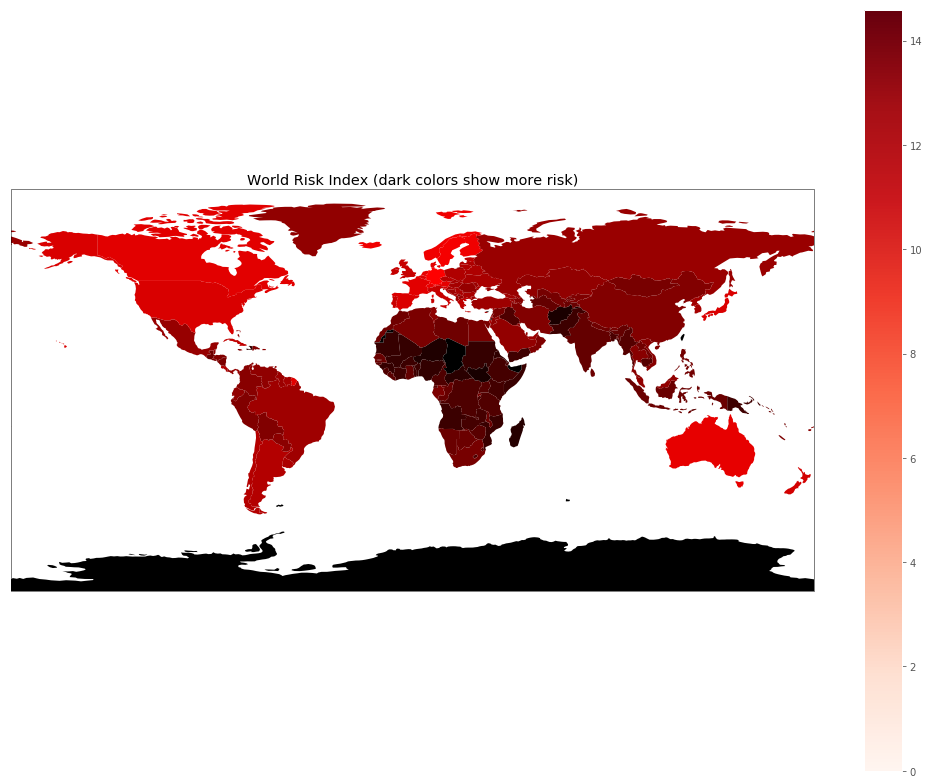

In [188]:
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.io.shapereader as shpreader
import itertools
import numpy as np

shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='110m',category='cultural', name=shapename)

earth_colors = np.array(df[['R','G','B']])
earth_colors = itertools.cycle(earth_colors)
plt.figure(figsize=[18,14])
ax = plt.axes(projection=ccrs.PlateCarree())
lister=[]
for country in shpreader.Reader(countries_shp).records():
    ax.add_geometries(country.geometry, ccrs.PlateCarree(),facecolor=next(earth_colors),label=country.attributes['NAME_LONG'])
plt.title("World Risk Index (dark colors show more risk)")
sm=plt.cm.ScalarMappable(cmap='Reds',norm=plt.Normalize(0,14.59))
sm._A=[]
plt.colorbar(sm,ax=ax)
plt.show()

<font color=blue> Exhibit 1 - Heat Map of the Risk Index as generated by us. 

The high risk countries areas are highlighted by deep dark colors. Most of Africa, South, Soth East, Central Asia, West Coast of South America are highlighted as very risky. This is very similar to the heat map generated by UNUEHS as shown below.
<br> 
<br>We have built the risk index for ourselves using data which is publically available. We had no access to the data used by UNU for their research. We used the same indices as used by UNU but sourced our own data and achieved results which corroborate UNU's findings. <br><br>

As you can see, there is no RISK FREE country. The West and Australia are less risky than the rest of World. This tells us that every country has its own set of risk factors. These could be due to exposures to hazards, or that the country is particularly susceptible to hazards, or that the country lacks coping capacities or that it doesn't have long term strategies to deal with the aftermath of hazards. Therefore, having one risk index score for the World is not a particularly intuitive way of looking at the true picture. Yes , it is a good way of getting an understanding of the World in a quick glance but we must look at the contributing factor for each country to make a decision about moving there or not. <br><br>

(Please ignore Antarctica and Greenland, as we had no data on them and the color coding for these two areas is not be relied upon) 

</font>

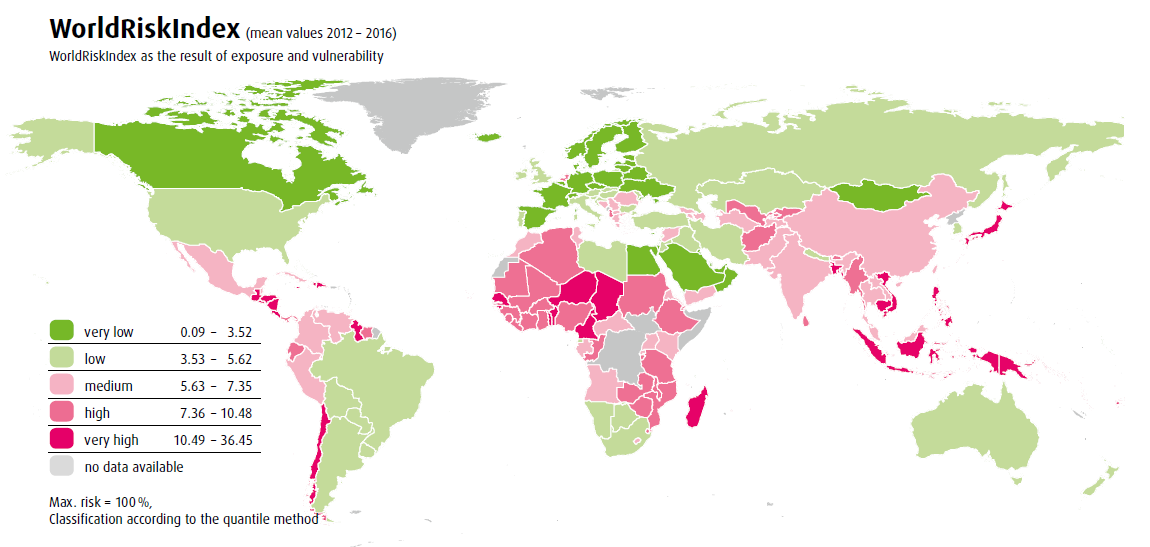

In [158]:
IPython.display.Image('Image6.PNG')

<font color=blue> Exhibit 2 - Heat Map of Risk Index as generated by the United Nations University UNU EHS - Institute for Environment and Human Safety - World Risk Report 2016<br><br>

We have been able to nearly recreate the world risk index by using publically available information.
<br><br>Expectedly many regions in the Asia Pacific and Western South America were found to be High Risk. This is owing to high susceptability due to environmental factors.
<br><br>Other nations such as the ones in Africa and Asia have elevated risk owing to elevated lack of coping and adaptive capacities as they're still struggling to end poverty.
<br><br> But before we paint countries with a broad-brush we must dig deeper into every country's contributing risk scores to find the true reasons behind its risk score. </font>

## ANALYSIS 2 - Hunt for countries which have poor Coping Capabilities and High Susceptability - Generate K=3 Means clusters for exploratory analysis

<font color=blue>  Why we are doing this ? Our hypothesis is that there exist three distinguishable groups of countries.The ones which are severely exposed and consequently needy, the others being moderately exposred, and lastly the ones that fair better than the other 2 groups. Let's see what we get.

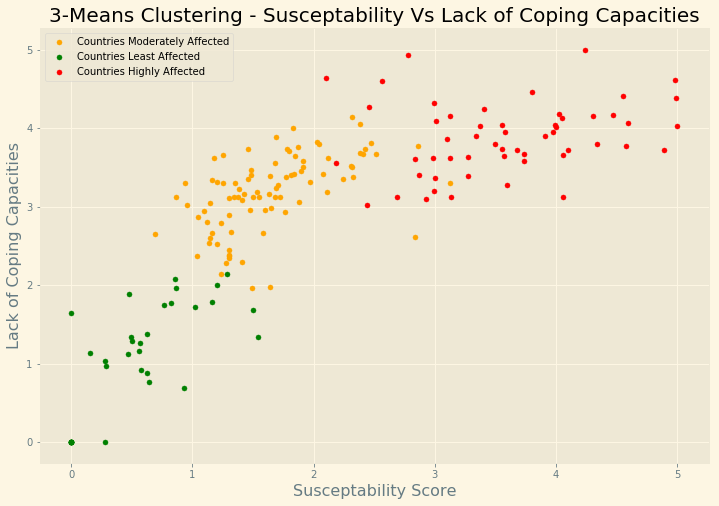

In [191]:
# Using the 4 sub scores to generate the 'distance' for KMeans. We hypothesize that 3 distinct clusters should be visible.
X=df[['HazardLoss', 'Susceptability Score',
       'Lack of Coping Capacities', 'Lack of adaptive capacities']].copy()
X['HazardLoss']=X['HazardLoss']
X['Susceptability Score']=X['Susceptability Score']
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3,n_init=100,max_iter=600)
y_pred = kmeans.fit_predict(X) #use K=3 , fit and predict the model
x_axis = X['Susceptability Score']
y_axis = X['Lack of Coping Capacities']
with plt.style.context('Solarize_Light2'):
    plt.figure(figsize = (12, 8))
    plt.scatter(x_axis[y_pred == 0], y_axis[y_pred==0], color = "orange", label = 'Countries Moderately Affected',s=25)
    plt.scatter(x_axis[y_pred == 1], y_axis[y_pred==1], color = "green", label = 'Countries Least Affected',s=25)
    plt.scatter(x_axis[y_pred == 2], y_axis[y_pred==2], color = "red", label = 'Countries Highly Affected',s=25)
    plt.xlabel('Susceptability Score',size=16)
    plt.ylabel('Lack of Coping Capacities',size=16)
    plt.title('3-Means Clustering - Susceptability Vs Lack of Coping Capacities',size=20)
    plt.legend()
    plt.show()

<font color=blue> 
High susceptability means high likelihood of suffering harm.
High 'Lack of Coping Capacities' means that the country has poor capacities too offset the impact of negative consequences.
It is evident that countries that are most susceptible also have the highest inability to cope with negative consequences. Our hypothesis has some story to tell. Let's see which are these countries.</font>

## ANALYSIS 3 - On a world map plot the countries that are highly susceptible and have poor coping capacities

In [171]:
dd=df['Country'].groupby(pd.DataFrame(y_pred)[0])# creating a group by Object

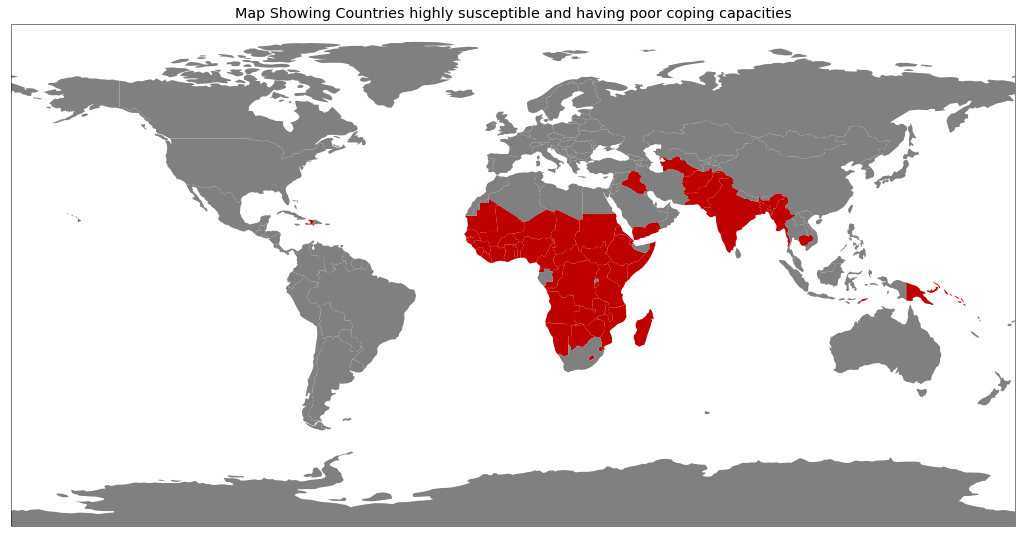

In [192]:
country=pd.DataFrame(columns=['Country','R','G','B'],index=range(len(countryCartopy.index)))
country['Country']=countryCartopy['0']
country.index=country['Country']
del country['Country']
country['R']=0.5
country['G']=0.5
country['B']=0.5
for i in dd.get_group(2):
    country.at[i,'G']=0
    country.at[i,'B']=0
    country.at[i,'R']=0.75

    shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='110m',category='cultural', name=shapename)

earth_colors = np.array(country[['R','G','B']])
earth_colors = itertools.cycle(earth_colors)
plt.figure(figsize=[18,14])
ax = plt.axes(projection=ccrs.PlateCarree())
lister=[]
for cntry in shpreader.Reader(countries_shp).records():
    ax.add_geometries(cntry.geometry, ccrs.PlateCarree(),facecolor=next(earth_colors),label=cntry.attributes['NAME_LONG'])
plt.title("Map Showing Countries highly susceptible and having poor coping capacities")
plt.show()

<font color=blue>  As we can see many countries are in this 'Highly Susceptible-Lacking coping capacities' category. Let us take the example of India. So which are the risks that any person who is wanting to move to India should be aware of ? How does India compare to the category average of High Risk countries. How does India compare to the World Average ? Let's try to find some answers. </font>

## Analysis 4 - If someone is planning to move to India for work, what should they know about the country ?

In [173]:
country=countryCartopy['0'].copy()
country=pd.concat([country,pd.DataFrame(y_pred)],axis=1)
country.columns=['Country','Cluster']
country.index=country.Country
del country['Country']
dtemp=df4sec.copy()
dtemp.index=dtemp.Country
del dtemp['Country']
del dtemp['R']
del dtemp['G']
del dtemp['B']
dd3=dtemp.groupby(country['Cluster'])
dfIndia = pd.concat([dd3.get_group(2).loc['India',:],dd3.get_group(2).mean(),dtemp.mean()],axis=1)
dfIndia.columns=['India','Category_Average','World_Average']
dfIndia

,India,Category_Average,World_Average
HazardLoss,0.005882,0.009712,0.110472
Susceptability Score,2.833561,3.606201,2.075825
Lack of Coping Capacities,3.611472,3.934907,3.125274
Lack of adaptive capacities,2.932857,3.395039,2.417836
risk_index,9.383772,10.945859,7.729407


<font color=blue> When India is compared to its category average and the world average this is what we see -

Compared to the world and its category, India actually has a lesser HazardLoss score. This tells us that over the last 5 years, the losses from Hazards in India as a percentage of its GDP have been much lower than its category average and world average. That means India doesn't seem to be affected significantly from hazards such as earthquakes, sea level rise, storms, floods and droughts. <br><br>So India's high risk_index score is not because it is affected by Hazards. Let's investigate further.
On the susceptability front, which tells us whether a country is likely to suffer harm, India seems to do much better than the category average. Which tells us that in the high risk category countries, India is not a very poor performer. But compared to the world average, India has a lot of catching up to do.
A similar trend as susceptability follows for Lack of Coping Capacities (Lack of capacities within the country that can help it to reduce negative consequences) and Lack of Adaptive Capacities(Lack of capacities for long term strategies for societal change). India fares better than the category average but lags behind the World Average. <br><br> By looking at the next table and seeing India's performance with respect to its category average and world average , one can get clues about where India is lacking. This can help a potential migrant on better understanding what he/she is getting into.  <font>

In [174]:
country=countryCartopy['0'].copy()
country=pd.concat([country,pd.DataFrame(y_pred)],axis=1)
country.columns=['Country','Cluster']
country.index=country.Country
del country['Country']
dd2=dfall.groupby(country['Cluster'])
dfIndia = pd.concat([dd2.get_group(2).loc['India',:],dd2.get_group(2).mean(),dfall.mean()],axis=1)
dfIndia.columns=['India','Category_Average','World_Average']
dfIndia.reset_index(drop=False,inplace=True)
dfIndia.columns=['Parameter', 'India', 'Category_Average', 'World_Average']
for i in dfIndia.index:
    if(i!=0):
        if(i<9):
            dfIndia.at[i,'Type_Of_Score']='Susceptability'
        elif(i<14):
            dfIndia.at[i,'Type_Of_Score']='Coping'
        else:
            dfIndia.at[i,'Type_Of_Score']='Adaptive'
    else:
        dfIndia.at[i,'Type_Of_Score']='Hazard'
dfIndia=dfIndia[['Parameter','Type_Of_Score', 'India', 'Category_Average', 'World_Average']]
dfIndia

,Parameter,Type_Of_Score,India,Category_Average,World_Average
0,HazardLossPercentage,Hazard,0.001176,0.001942,0.022094
1,ShrOfPpleSnt_AVG,Susceptability,0.343959,0.302817,0.702081
2,ShrOfPpleWater_AVG,Susceptability,0.889675,0.513862,0.808816
3,ShrOfPpleSlums_AVG,Susceptability,0.205327,0.579414,0.427032
4,ShrOfPpleUnder_Index,Susceptability,0.960089,0.482180,0.278694
5,DependencyRatio_AVG,Susceptability,0.889675,0.513862,0.808816
6,Poverty_AVG,Susceptability,0.035536,0.052005,0.204123
7,GDP_AVG,Susceptability,0.039311,0.033089,0.139890
8,IncmGINI_Index,Susceptability,0.328537,0.498502,0.421502
9,CorruptionIndex_AVG,Coping,0.354369,0.254393,0.427097


<font color=blue> Note 1 : The values shown above are not proportions. These values have been scaled. So only a relative comparison should be made. No absolute value should be taken from this table.
<br>Note 2 : Some parameters are on an inverted scale. Before making a relative comparison, check the individual sub index calculation formula to understand the scale. For example, on Poverty is on an inverted scale. The World performs better than India on this front even though the world score is higher than India's.</font>

## ANALYSIS 4 - On a world map plot the countries that are moderately susceptible and have moderate coping capacities

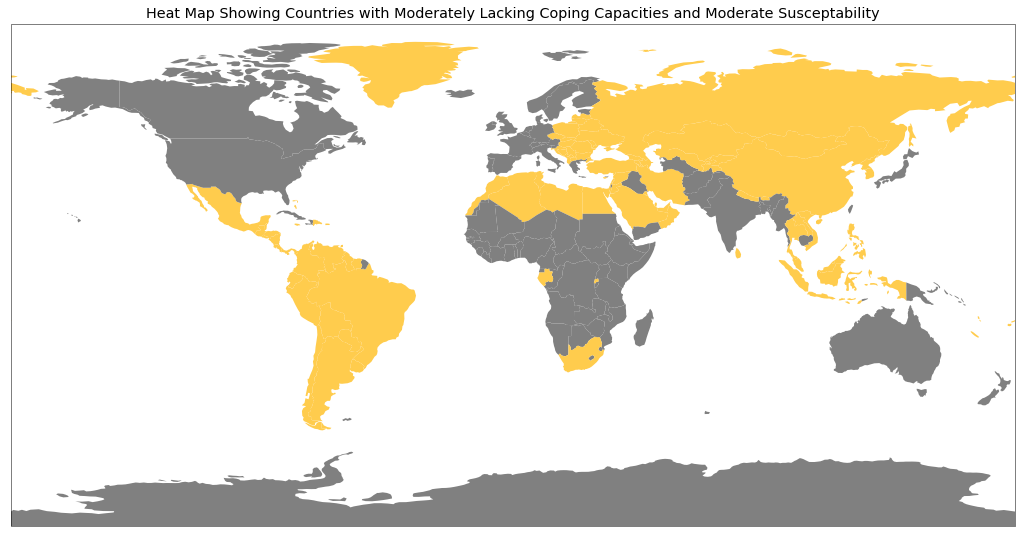

In [175]:
country=pd.DataFrame(columns=['Country','R','G','B'],index=range(len(countryCartopy.index)))
country['Country']=countryCartopy['0']
country.index=country['Country']
del country['Country']
country['R']=0.5
country['G']=0.5
country['B']=0.5
for i in dd.get_group(0):
    country.at[i,'G']=0.8
    country.at[i,'B']=0.3
    country.at[i,'R']=1

    shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='110m',category='cultural', name=shapename)

earth_colors = np.array(country[['R','G','B']])
earth_colors = itertools.cycle(earth_colors)
plt.figure(figsize=[18,14])
ax = plt.axes(projection=ccrs.PlateCarree())
lister=[]
for cntry in shpreader.Reader(countries_shp).records():
    ax.add_geometries(cntry.geometry, ccrs.PlateCarree(),facecolor=next(earth_colors),label=cntry.attributes['NAME_LONG'])
plt.title("Heat Map Showing Countries with Moderately Lacking Coping Capacities and Moderate Susceptability")
plt.show()

## ANALYSIS 5 - On a world map plot the countries that are least susceptible and have highest coping capacities

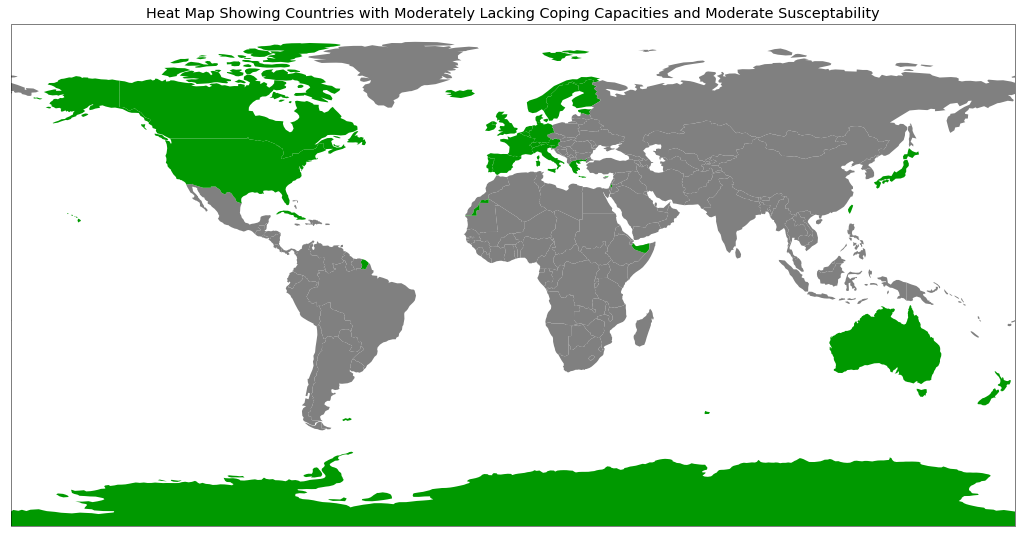

In [176]:
country=pd.DataFrame(columns=['Country','R','G','B'],index=range(len(countryCartopy.index)))
country['Country']=countryCartopy['0']
country.index=country['Country']
del country['Country']
country['R']=0.5
country['G']=0.5
country['B']=0.5
for i in dd.get_group(1):
    country.at[i,'G']=0.6
    country.at[i,'B']=0.0
    country.at[i,'R']=0.0

    shapename = 'admin_0_countries'
countries_shp = shpreader.natural_earth(resolution='110m',category='cultural', name=shapename)

earth_colors = np.array(country[['R','G','B']])
earth_colors = itertools.cycle(earth_colors)
plt.figure(figsize=[18,14])
ax = plt.axes(projection=ccrs.PlateCarree())
lister=[]
for cntry in shpreader.Reader(countries_shp).records():
    ax.add_geometries(cntry.geometry, ccrs.PlateCarree(),facecolor=next(earth_colors),label=cntry.attributes['NAME_LONG'])
plt.title("Heat Map Showing Countries with Moderately Lacking Coping Capacities and Moderate Susceptability")
plt.show()

## ANALYSIS 6 - In one picture display the distribution of data points in all of the 25 indicator variables

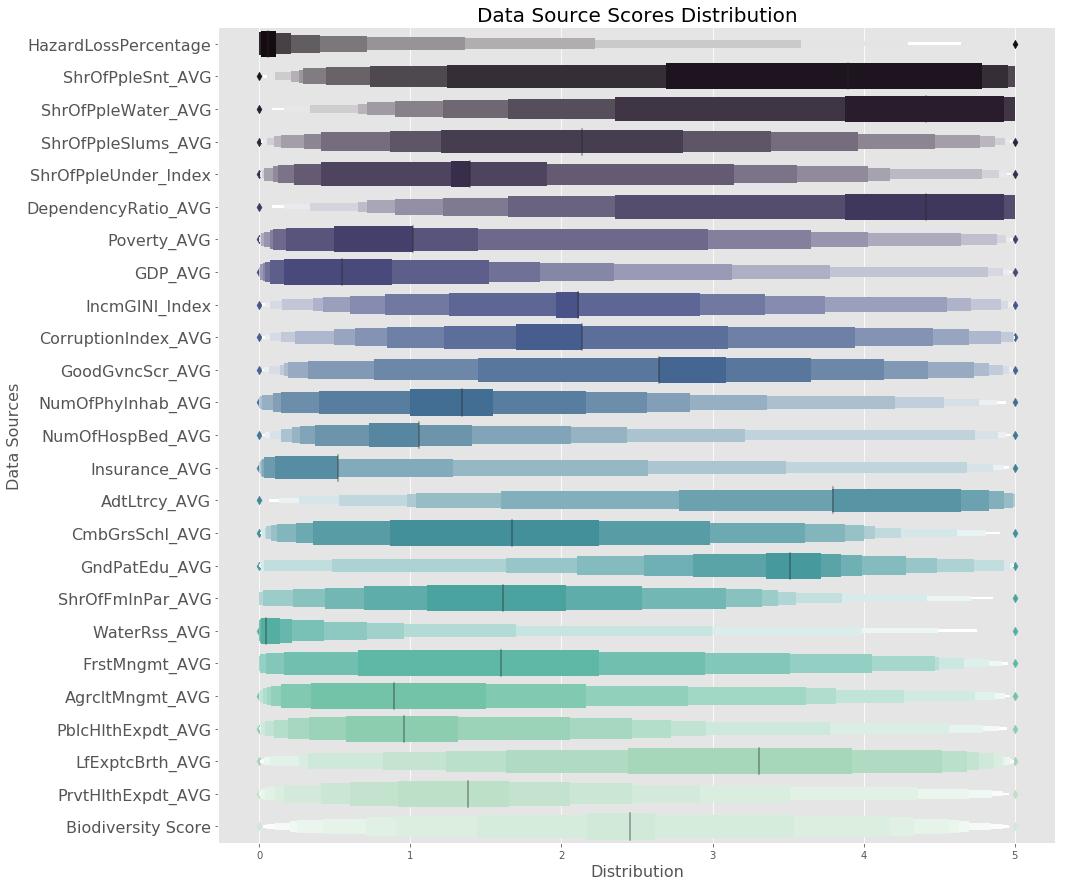

In [195]:
plt.figure(figsize=(15,15))
plt.title('Data Source Scores Distribution',fontsize=20)
plt.ylabel('Data Sources',fontsize=16)
plt.xlabel('Distribution',fontsize=16)
plt.yticks(fontsize=16)
sns.lvplot(data=dfall*5,scale='linear', palette="mako",orient='horizontal') # times 5 because we scaled them, but the range is 0-1.

<font color=blue> The reader can get a quick bird's eye view of the distribution within each indicator vairable. We scaled each score from 0 to 5. <br><br>

The reader can understand that some parameters are concentrated in one direction. That means the world is probably showing a trend. If the country he/she wants to migrate to bucks the global trend then it could be a sign to them to dig deeper. So for example, if the world is showing a concentration of public health expenditure scores in the region around 1 in this plot,  but India bucks that trend by lagging the world trend, then the reader can understand that India needs to do better on this aspect. This requires a social reform in India. </font>

# ANALYSIS 7 - Susceptability Score Distribution

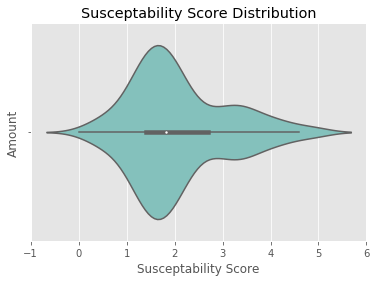

In [196]:
import seaborn as sns
plt.title('Susceptability Score Distribution')
plt.ylabel('Amount')
sns.violinplot(df4sec['Susceptability Score'],palette='GnBu')

<font color=blue> Analysis of Susceptability Score Distribution:  From the violin plot we can see that the 'S' score of most countries falls around 2, which means most countries are moderately threatened threatened by Hazards. Only few of the countries have low 'S' score but a greater number seems to be susceptible as evidenced from the longer right tail. This shows that many countries are susceptible. </font>

## ANALYSIS 8 - Coping Capacity Distribution

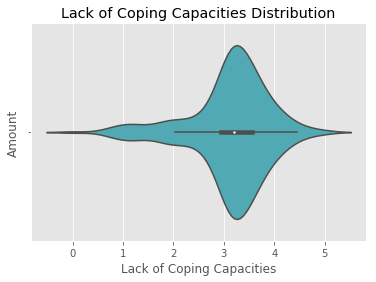

In [197]:
plt.title('Lack of Coping Capacities Distribution')
plt.ylabel('Amount')
sns.violinplot(df4sec['Lack of Coping Capacities'],palette='YlGnBu')

<font color=blue> Most countries have a 3 or above score which means many countries can quickly react to hazards. Countries with low scores should learn how to deal with risks from coutries with high score. These low scoring countries need the most urgent help in setting up infrastructure, policies and processess to deal with the immediate aftermath of hazards and calamities. </font>

## ANALYSIS 9 - Adaptive Capacity Distribution

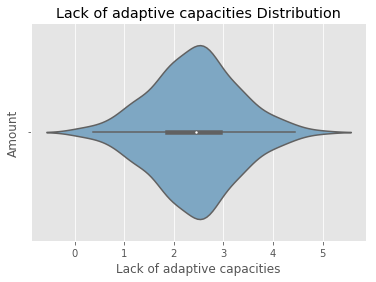

In [201]:
plt.title('Lack of adaptive capacities Distribution')
plt.ylabel('Amount')
sns.violinplot(df4sec['Lack of adaptive capacities'],palette='PuBu')

<font color=blue> Most countries have a 2.5 or above score which means the world average is literally an average when it comes to building long term strategies that can help nations combat the harmful impact of hazards in the long term. Countries with low scores should learn how to build institutions, policies and processes from countries with a high score. These low scoring countries need the most urgent help in strategy development, for which institutions like the World Bank can play a significant role. </font>

## ANALYSIS 10 - Corruption and Fragility

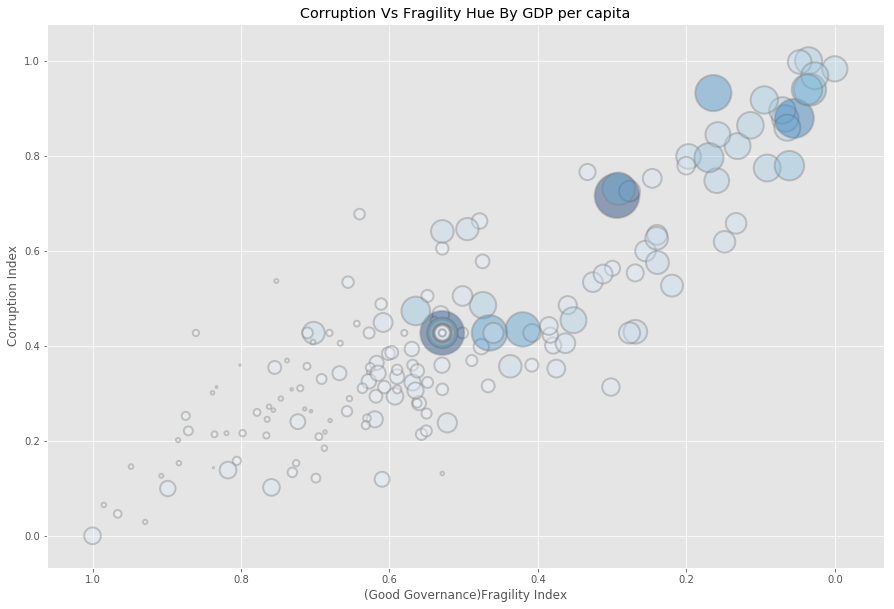

In [219]:
###### Governance plot #################
x = dfall.GoodGvncScr_AVG
y = dfall.CorruptionIndex_AVG
z = dfall.GDP_AVG
plt.figure(figsize=(15,10))
# Change color with c and alpha. I map the color to the X axis value.
plt.scatter(x, y, s=z*2000,c=z, cmap="Blues", alpha=0.4, edgecolors="grey", linewidth=2)
plt.gca().invert_xaxis()
# Add titles (main and on axis)
plt.xlabel("(Good Governance)Fragility Index")# Inverted scale. Higher the score worse the fragility
plt.ylabel("Corruption Index") # Higher the score lower is the perceived corruption in the country
plt.title("Corruption Vs Fragility Hue By GDP per capita")
plt.show()

<font color=blue> There is a definite correlation between lesser fragility, lesser perceived corruption and GDP per capita. This chart tells us that countries with less fragility (best countries are with score 0) and countries with least corruption (least corruption is shown as 1 on the y-axis) tend to have the highest GDP per capita. This plot can be used by any migrant to understand the gro-political environment of the country he/she wants to move to.</font>

## ANALYSIS 11 - Corruption and Biodiversity

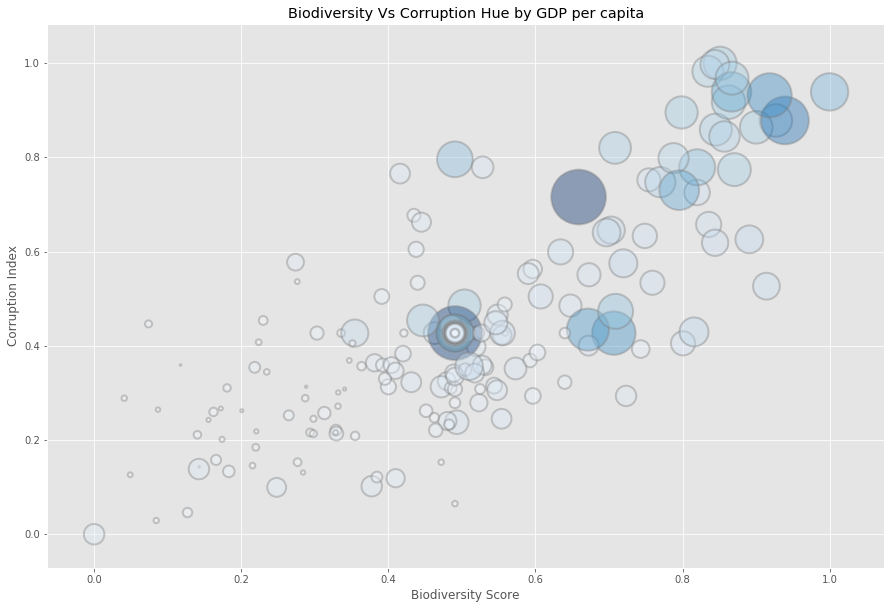

In [213]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
 
# create data
x = dfall['Biodiversity Score']
y = dfall.CorruptionIndex_AVG
z = dfall.GDP_AVG
plt.figure(figsize=(15,10))
# Change color with c and alpha. I map the color to the X axis value.
plt.scatter(x, y, s=z*3000, c=z, cmap="Blues", alpha=0.4, edgecolors="grey", linewidth=2)

# Add titles (main and on axis)
plt.xlabel("Biodiversity Score")
plt.ylabel("Corruption Index")
plt.title("Biodiversity Vs Corruption Hue by GDP per capita")

plt.show()

<font color=blue> 
We found an interesting relation between corruption score and biodiversity score. Countries that are perceived to be less corrupt also have a higher and better score for biodiversity. But there are many countries that have an average score on biodiversity and a below average score on corruption. This is what Economists call as the - Curse of the Natural Resources. These countries are plagued with autocracies and poor governance. A migrant could use this plot to understand what he/she should expect from the government of the country to which he/she wants to migrate.</font>

## ANALYSIS 12 - Spider Plot

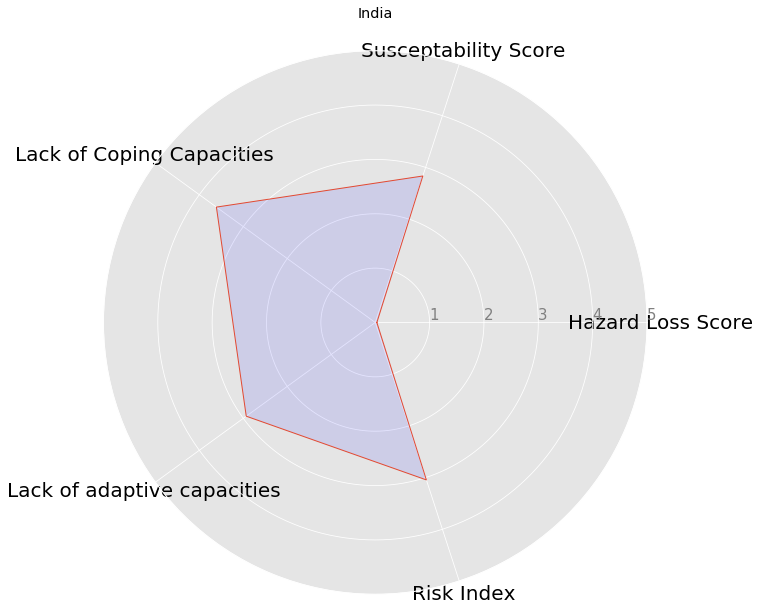

In [223]:
# Libraries
import matplotlib.pyplot as plt
from math import pi
##### put the country you want to analyze ##########
x='India'
# Set data
df_map=df4sec[df4sec.HazardLoss<=1]
index=df_map[df_map.Country==x].index
df_map=df_map.iloc[:,1:6].apply(lambda x:(x-x.min())*5/(x.max()-x.min()))
df = df_map.loc[index].iloc[:,0:5]
# number of variable
categories=['Hazard Loss Score','Susceptability Score', 'Lack of Coping Capacities','Lack of adaptive capacities', 'Risk Index']
N = len(categories)
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=df.values.flatten().tolist()
values += values[:1]
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
# Initialise the spider plot
plt.figure(figsize=(15,10))
ax = plt.subplot(111, polar=True)
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='black', size=20)
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([1,2,3,4,5], ["1","2","3","4","5"], color="grey", size=15)
plt.title('%s'% x) 
plt.ylim(0,5)
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')
# Fill area
ax.fill(angles, values, 'b', alpha=0.1)

<font color=blue> This plot shows how all the subscores come together and form the final risk index for India. For India, it is not the Exposure Score that impacts its rating negatively, but the Susceptability, Lack of Coping and Adaptive Capacities do much damage to its rating. India is a developing country and need to foster stronger institutions, policies and processes that will help it cope and adapt to the challenges of hazards and calamities, if they ever strike India. </font>

# Section 4 - Conclusion

<font color=blue> 
1. The Risk Index is a visual tool that can help any migrant or traveller gauge country risk.<br>
2. Country risk has 4 components - Exposure to hazards (in our case, we are considering natural hazards), Susceptability (likelihood of harm), Lack of Coping Capacities (to deal with the immediate aftermath of a calamity), Lack of Adaptive Capacities (to deal with the aftermath of a calamity in the long term).<br>
3. The average world mean risk_index score is 7.729 (raw score) and no country in the world is devoid of risk.<br>
4. Some countries have an elevated score because of 1 parameter out of 4, and some countries have elevated scores on all 4 parameters.<br>
5. Our test case India was found to be better off than its category average and global average on Exposure Score. But on the other 3 scores, India has a lot of catching up to do with the Global Average.<br>
6. Because we have 25 indicator variables for our risk index score, it is possible to dig deep into our data and fathom the exact reason why a country has a bad score. This analysis can tell a migrant a lot about the country he/she wants to migrate to.<br>



</font>

**Bibliography**<br>
Welthungerhilfe, United Nations University, medico international, Terre des hommes, CBM, Kindernothilfe. "World Risk Report Analysis and Prospects 2017." 2017. https://reliefweb.int/report/world/world-risk-report-2017. 

